## Soleil DiffAbs XRD:
* [Calibration](#calibration)
* [Dark](#dark)
* [Flat](#flat)
* [Mask](#dark)
* [Integration](#integration)

## Calibration ImXPadS140 <a name="calibration"></a>

This tutorial is for the calibration of an Xpad_s140 on the Soleil DiffAbs Diffractometer.

The calibration data is a scan on the delta motor with a CeO2 calibrant.
The incident beam energy was : 18.2keV


In [20]:
%matplotlib notebook

# first the imports
from typing import Iterator, List, NamedTuple, Optional, Text, Tuple

import copy
import os
import functools
import time

from collections import namedtuple
from math import pi

import numpy
import pylab
import pyFAI
import scipy.stats

import ipywidgets as widgets

from h5py import Dataset, File
from IPython.display import display
from numpy import ndarray
from pyFAI.detectors import detector_factory
from pyFAI.gui import jupyter

# local import
from soleil import Angle, Calibrant, Calibration, CalibrationFunctions, CalibrationFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathWithAttribute, get_dataset,\
    calibration, integrate, save_as_edf

In [21]:
# temporary until the ruch is ON
ROOT = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20170063", "2017", "Run5")

PUBLISHED = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20170063", "published-data")

COM_DIFFABS = os.path.join("/nfs", "ruche-diffabs", "diffabs-soleil", "com-diffabs")

# Flat
ROOT_FLAT = os.path.join("/nfs", "ruche-diffabs", "diffabs-users", "20170063")

# Dark
ROOT_DARK = COM_DIFFABS


In [3]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.
# TODO ajout du mask pour la calibration

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = Length(3.88099e-01)
poni1 = Length(1.307413e-01)
poni2 = Length(3.010775e-02)
rot1_scale = -1
rot1_offset = Angle(-16)
rot2 = Angle(0)
rot3 = Angle(0)

functions = (
    CalibrationFunctions("dist", "poni1", "poni2",
                         "pi * (rot1_scale * delta + rot1_offset) / 180",
                         "rot2",
                         "rot3"),
    [Parameter[Length]("dist", distance, (distance-0.01, distance+0.01)),
     Parameter[Length]("poni1", poni1, (poni1-0.1, poni1+0.1)),
     Parameter[Length]("poni2", poni2, (poni2-0.1, poni2+0.1)),
     Parameter[float]("rot1_scale", rot1_scale, (rot1_scale, rot1_scale)),
     Parameter[Angle]("rot1_offset", rot1_offset, (rot1_offset-0.5, rot1_offset+0.5)),
     Parameter[float]("rot2", rot2, (rot2-0.2, rot2+0.2)),
     Parameter[Angle]("rot3", rot3, (rot3, rot3))]
)

def to_use(frame: CalibrationFrame) -> bool:
    return False if frame.idx in [8,10,11] else True

params = Calibration(os.path.join(PUBLISHED, "xrd", "calibration"),
                     os.path.join(ROOT, "2017-11-15", "scan_81.nxs"),
                     DatasetPathWithAttribute("interpretation", b"image"),
                     DatasetPathContains("scan_data/actuator_1_1"),
                     [1,2,3,4,5,6,7,9,12],
                     to_use,
                     Calibrant("CeO2"),
                     Detector("imxpads140"),
                     Wavelength(6.81231e-11),
                     functions
                    )

In [4]:
from functools import partial

def on_click_button(cmd, b):
    print(cmd)
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
silx = my_cmd_button("silx view --use-opengl-plot " + params.filename,
                     'Silx View ' + os.path.basename(params.filename))

In [6]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

cmds = save_as_edf(params)
buttons = []
for cmd, idx in zip(cmds, params.idxs):
    buttons.append(my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(params.filename) + " " + str(idx)))

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.812310e-11m
SampleDetDist= 3.843099e-01m	PONI= 3.708913e-02, 1.008074e-01m	rot1=-0.025381  rot2= -0.048124  rot3= 0.000000 rad
DirectBeamDist= 384.879mm	Center: x=850.489, y=142.879 pix	Tilt=3.117 deg  tiltPlanRotation= -62.214 deg
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.812310e-11m
SampleDetDist= 3.345634e-01m	PONI= 1.324506e-01, -7.578622e-02m	rot1=-0.599164  rot2= -0.302084  rot3= -0.000003 rad
DirectBeamDist= 424.350mm	Center: x=1174.544, y=47.709 pix	Tilt=37.963 deg  tiltPlanRotation= -28.924 deg
Detector Imxpad S140	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 6.812310e-11m
SampleDetDist= 3.973205e-01m	PONI= -1.707271e-02, 3.304909e-02m	rot1=-0.343485  rot2= 0.082164  rot3= -0.000004 rad
DirectBeamDist= 423.397mm	Center: x=1347.353, y=135.969 pix	Tilt=20.214 deg  tiltPlanRotation= 13.741 deg
Detector Imxpa

<IPython.core.display.Javascript object>


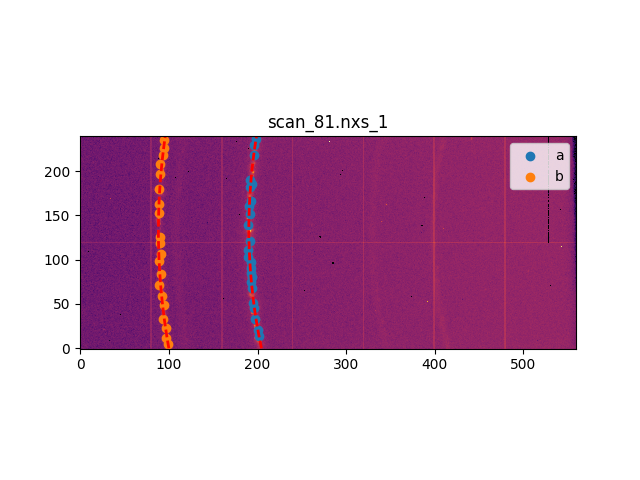

<IPython.core.display.Javascript object>


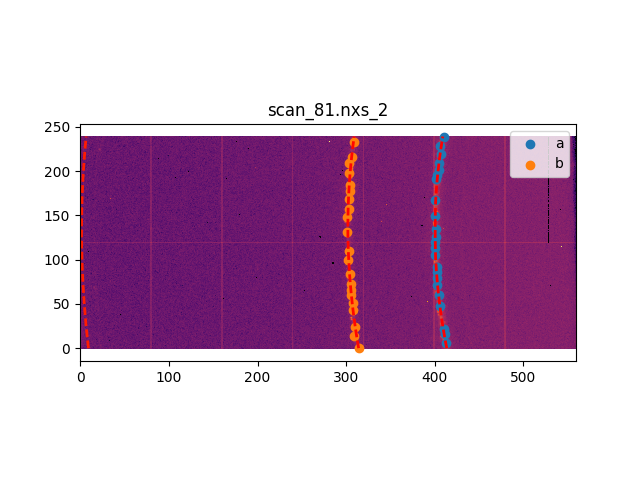

<IPython.core.display.Javascript object>


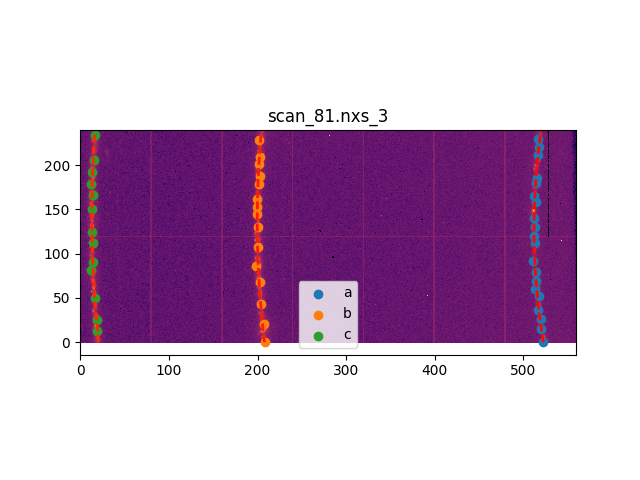

<IPython.core.display.Javascript object>


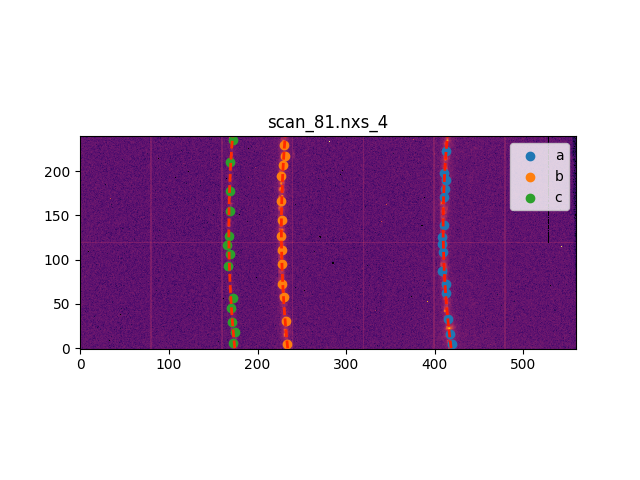

<IPython.core.display.Javascript object>


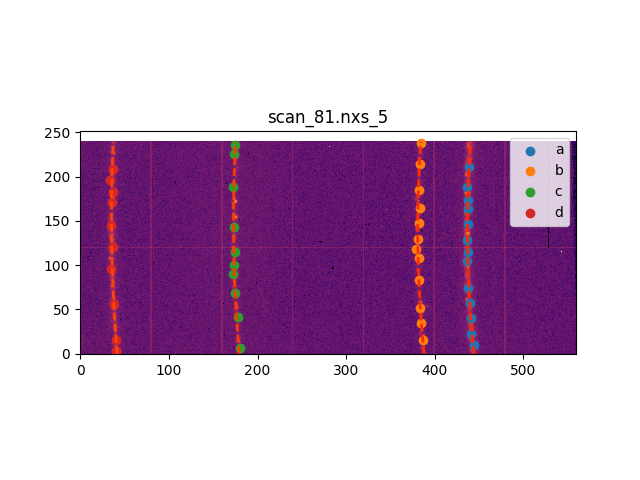

<IPython.core.display.Javascript object>


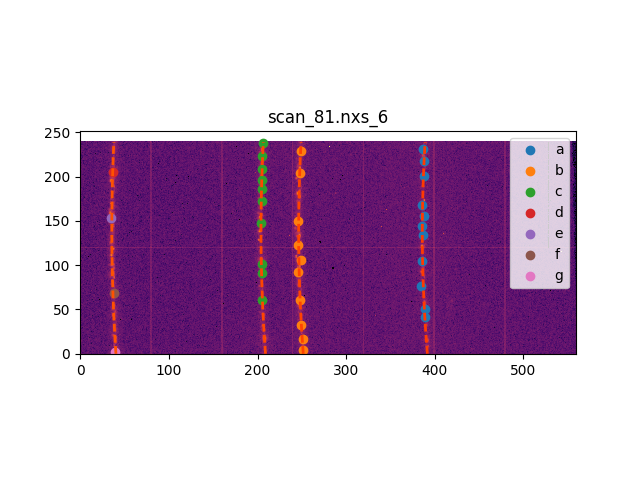

<IPython.core.display.Javascript object>


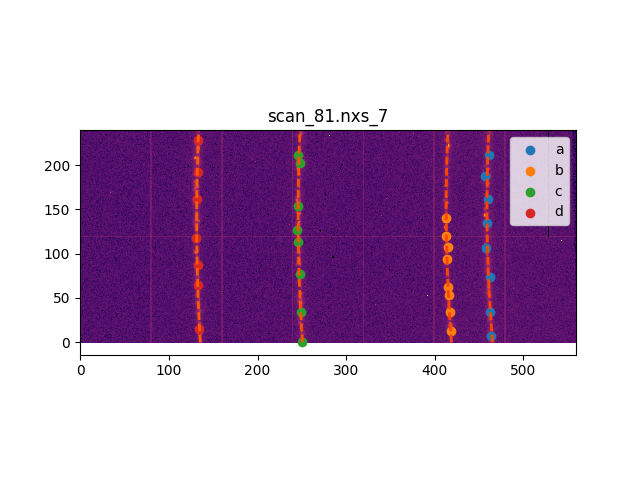

<IPython.core.display.Javascript object>


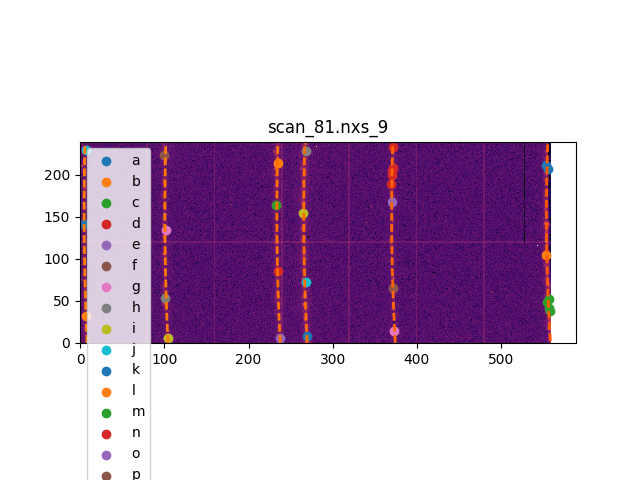

<IPython.core.display.Javascript object>


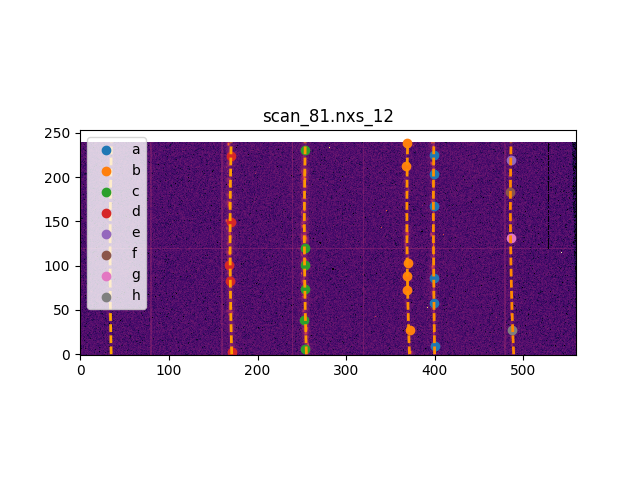

Cost function before refinement: 0.00356707209413
[  0.388099     0.1307413    0.03010775  -1.         -16.           0.           0.        ]
     fun: 2.132159346280713e-07
     jac: array([ -5.04724567e-06,   1.18020302e-05,   7.23577783e-07,
         6.53346595e-05,   1.09650777e-09,   1.43231809e-08,
        -5.86197757e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 244
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([  0.398099  ,   0.0307413 ,   0.05660352,  -1.        ,
       -16.00013456,  -0.03024065,   0.        ])
Cost function after refinement: 2.13215934628e-07
GonioParam(dist=0.39809900000000004, poni1=0.030741300000000003, poni2=0.056603518603514182, rot1_scale=-1.0, rot1_offset=-16.000134560413812, rot2=-0.030240650082290238, rot3=0.0)
maxdelta on: poni1 (1) 0.1307413 --> 0.0307413

scan_81.nxs_0
ControlPoints instance containing 0 group of point:
CeO2 Calibrant with 41 reflections at wavelength 6.81231e-11
Con

<IPython.core.display.Javascript object>


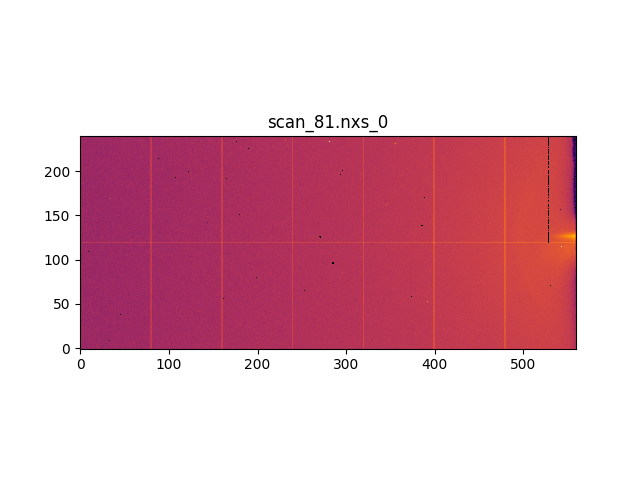

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<IPython.core.display.Javascript object>


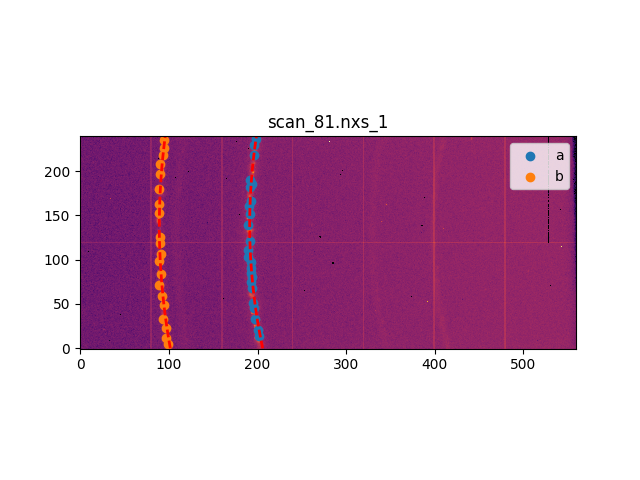

<IPython.core.display.Javascript object>


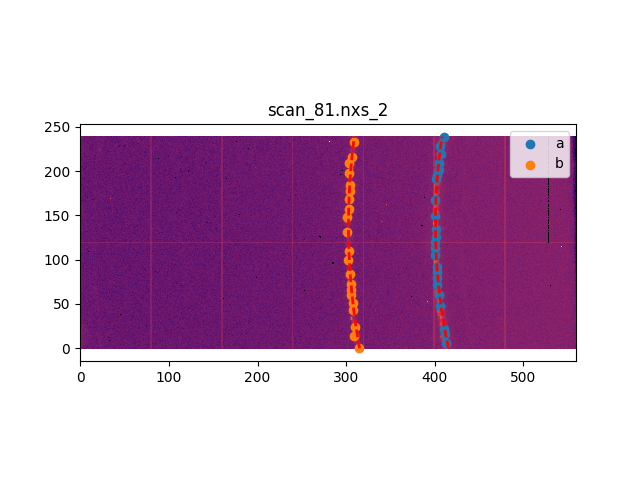

<IPython.core.display.Javascript object>


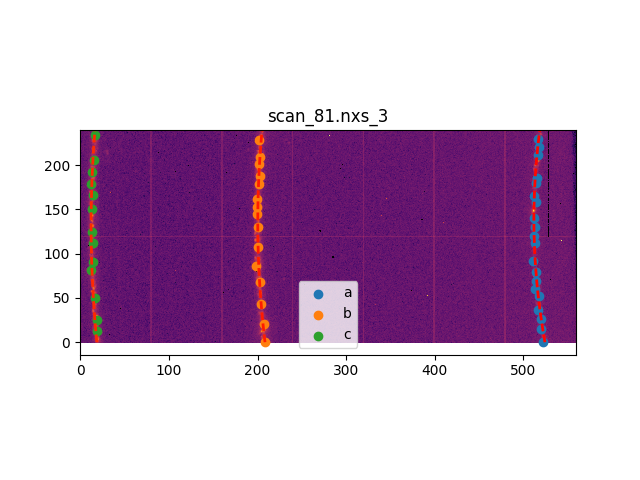

<IPython.core.display.Javascript object>


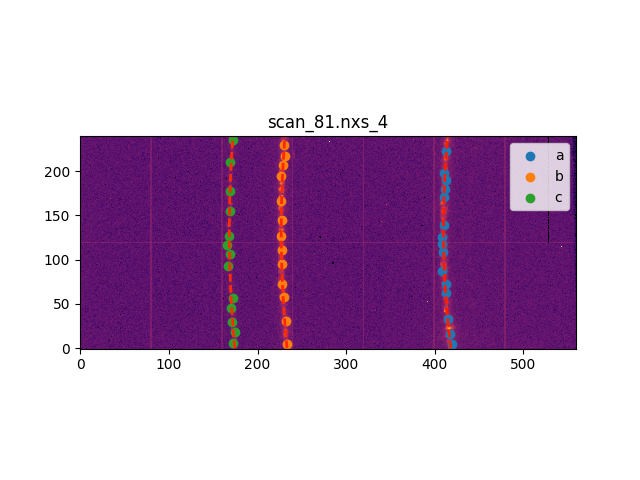

<IPython.core.display.Javascript object>


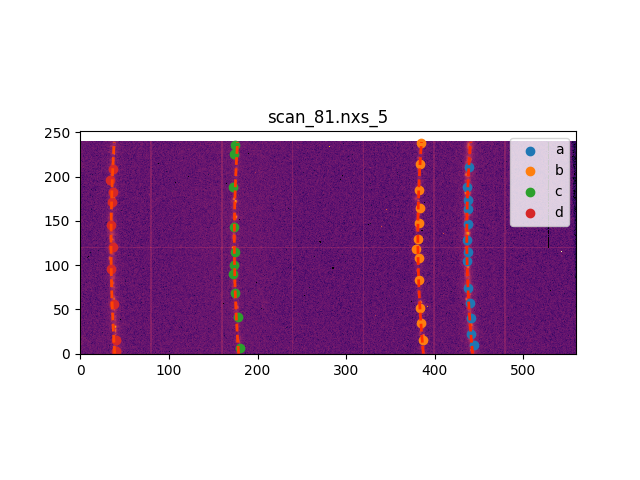

<IPython.core.display.Javascript object>


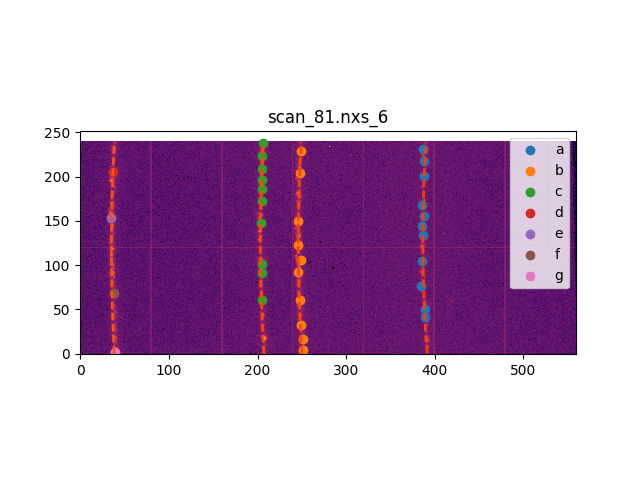

<IPython.core.display.Javascript object>


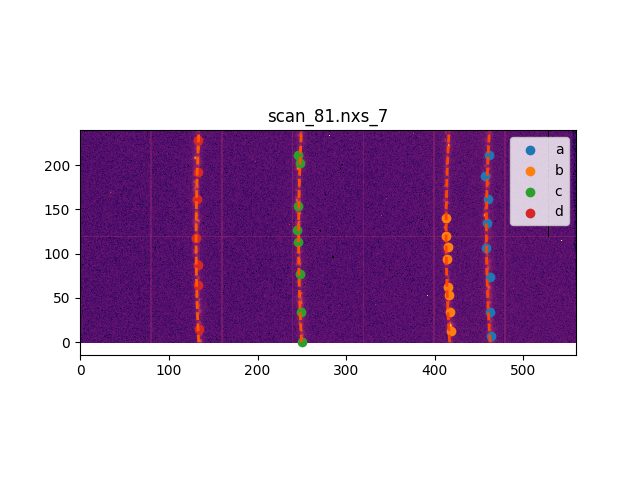

<IPython.core.display.Javascript object>


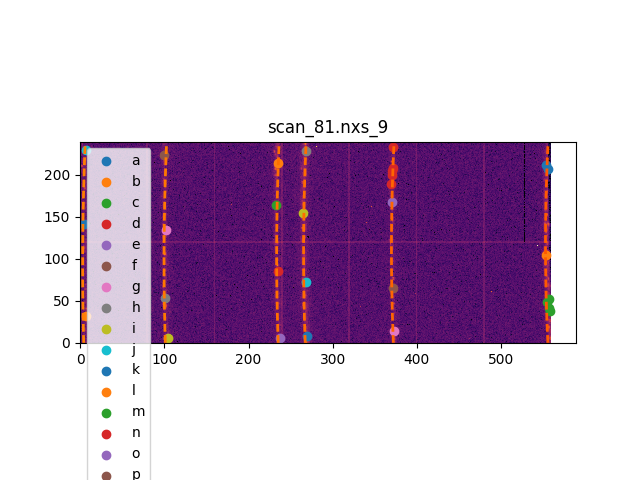

<IPython.core.display.Javascript object>


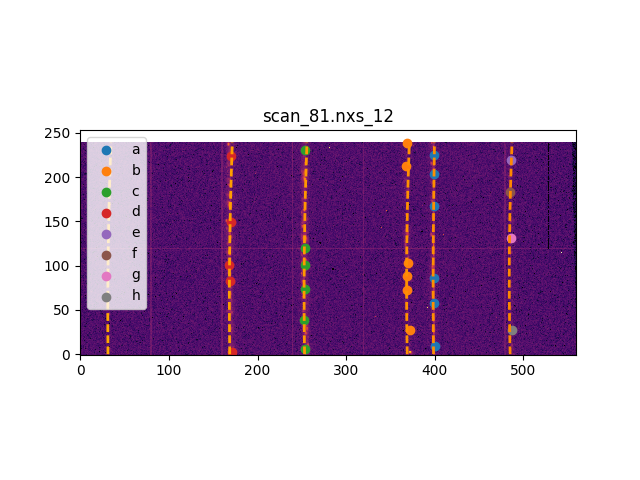

<IPython.core.display.Javascript object>


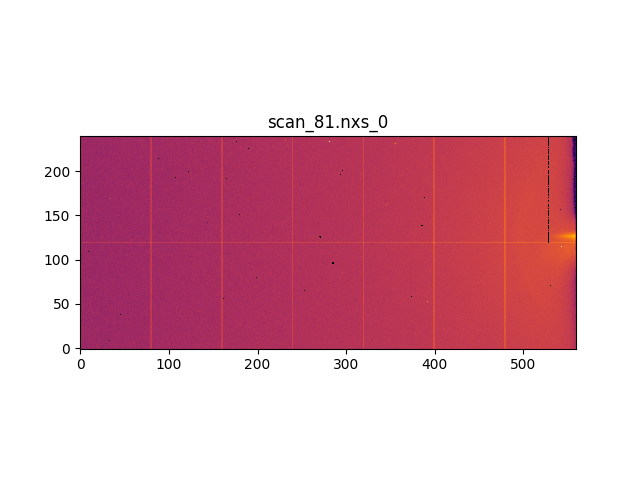

In [7]:
# execute the calibration

calibration(json, params)

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


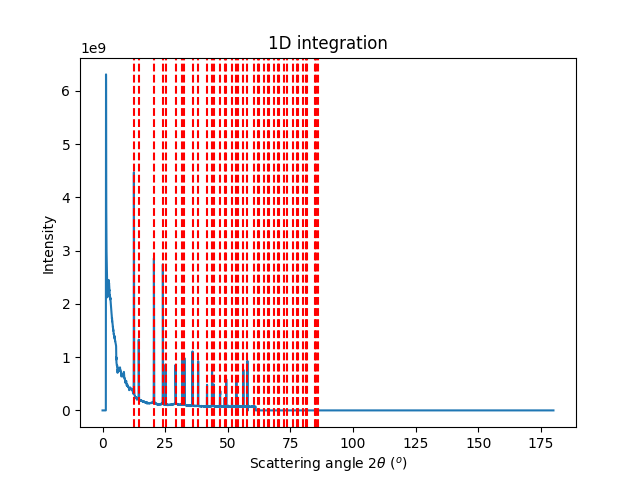

(array([  9.00000107e-03,   2.70000011e-02,   4.50000011e-02, ...,
          1.79955000e+02,   1.79973000e+02,   1.79991000e+02]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [12]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 4400, 0, img)
    return img

integrate(json, params, f, plot_calibrant=True, n=10000, save=True)

## Dark <a name="dark"></a>

In [13]:
# Compute the mask and the dark
# 3.5 could be simplify with 3.6
# TODO
# - boutons pour visualiser les mask
# - trouver en plus du mask standard, les pixels bizards.
#   - qui ne comptent pas.
#   - afficher une images des ecarts types spatiaux + temporels.

DarkMaskSources = NamedTuple('DarkMaskSources', [('filenames', List[Text]),  # name of the files
                                                 ('threshold', int),  # mask all pixel above this treshold
                                                 ('detector', Optional[Text]),
                                                 ('images_path', DatasetPath)])

darkMaskSources = DarkMaskSources([os.path.join(COM_DIFFABS, "2018", "Run3", "2018-05-17", "scan_21.nxs")],
                                  1, 'imxpad_s140',
                                  DatasetPathWithAttribute("interpretation", b"image"))

In [14]:
# display all the dark & mask images

for filename in darkMaskSources.filenames:
    my_cmd_button("silx view --use-opengl-plot " + filename,
                  'Silx View ' + os.path.basename(filename))

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


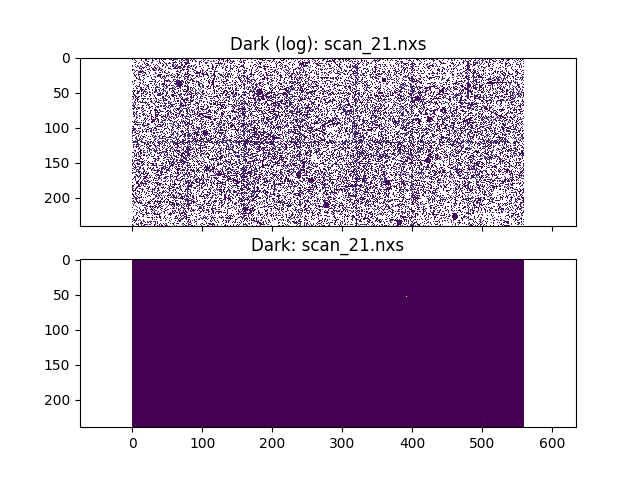

/usr/lib/python3/dist-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


In [15]:
#definition du dark à partir du fichier acquis

def make_dark(params: DarkMaskSources) -> ndarray:
    for filename in params.filenames: 
        with File(filename, mode='r') as f:
            images = get_dataset(f, params.images_path)[:].astype("double")
            dark = images.mean(axis=0)

            fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
            ax0 = ax[0]
            ax0.imshow(numpy.log(dark))
            ax0.set_title("Dark (log): " + os.path.basename(params.filenames[0]))
            ax1 = ax[1]
            ax1.imshow(dark)
            ax1.set_title("Dark: " + os.path.basename(params.filenames[0]))

            return dark
            
dark= make_dark(darkMaskSources)

## Flat  <a name="flat"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


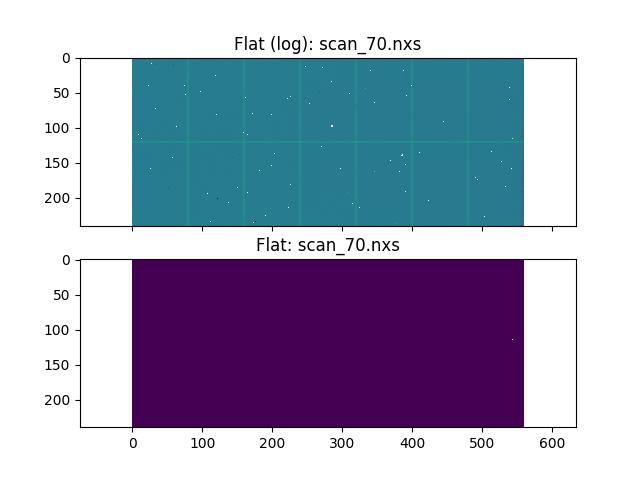

flat time:  0.2835240364074707


/usr/lib/python3/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log
/usr/lib/python3/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log


In [17]:
# compute the flat

FlatParams = NamedTuple('FlatParams', [('filename', Text),  # name of the file
                                       ('dark', Optional[ndarray]),
                                       ('images_path', DatasetPath)])

def get_flat(params: FlatParams) -> ndarray:
    """
    :param filename: name of the files
    :type filename: list(str)

    génère un flat corrigé du dark si dark is not None
    """
    with File(params.filename, mode='r') as f:
        images = get_dataset(f, params.images_path)[:].astype("double")
        flat = images.mean(axis=0)
        if dark is not None:
            flat -= dark

        return flat

t0 = time.time()
flatParams =  FlatParams(os.path.join(ROOT_FLAT, "2017", "Run5", "2017-11-15", "scan_70.nxs"),
                         dark,
                         DatasetPathWithAttribute("interpretation", b"image"))
flat = get_flat(flatParams)
#flat = numpy.where(flat<1, 1, flat)

fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
ax0 = ax[0]
ax0.imshow(numpy.log(flat))
ax0.set_title("Flat (log): " + os.path.basename(flatParams.filename))
ax1 = ax[1]
ax1.imshow(flat, vmin=0)
ax1.set_title("Flat: " + os.path.basename(flatParams.filename))


print("flat time: ", time.time() - t0)

In [18]:
# Add a button in order to explore the flat file

silx_flat = my_cmd_button("silx view --use-opengl-plot " + flatParams.filename,
                          'Silx View ' + os.path.basename(flatParams.filename))

## Mask  <a name="mask"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


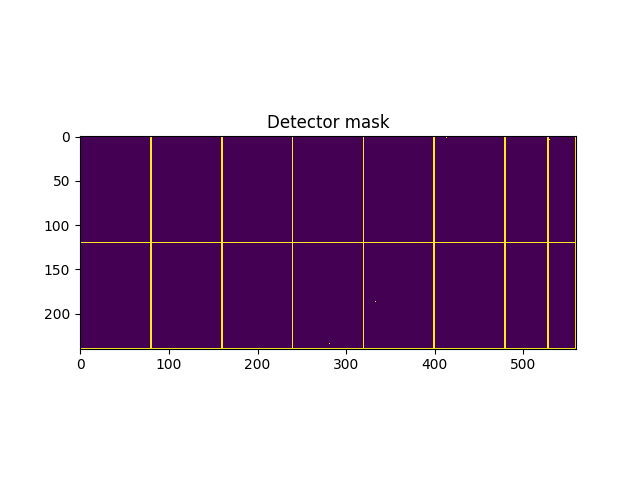

<IPython.core.display.Javascript object>


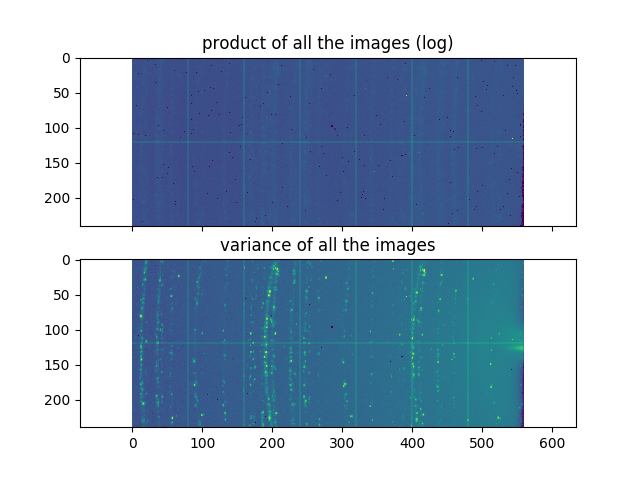

<IPython.core.display.Javascript object>


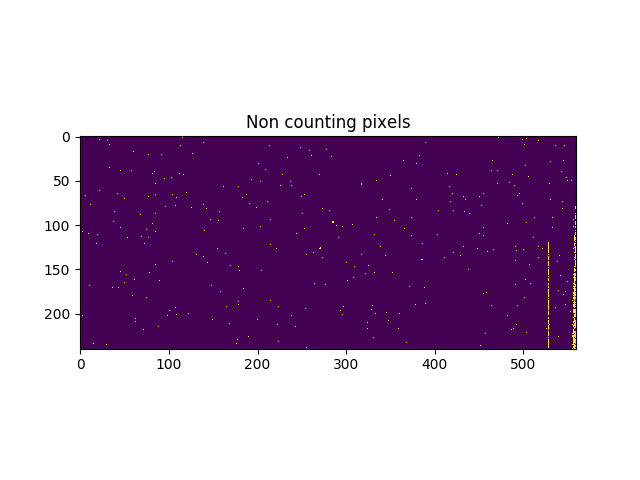

<IPython.core.display.Javascript object>


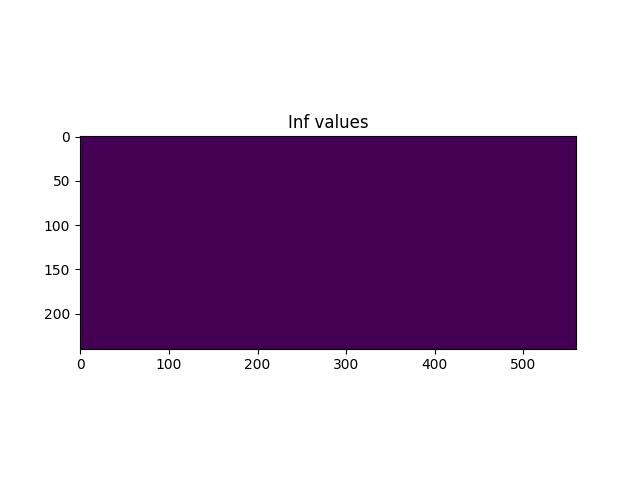

<IPython.core.display.Javascript object>


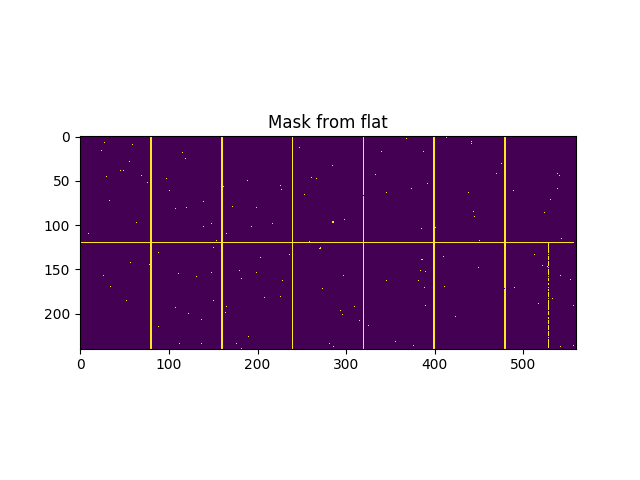

<IPython.core.display.Javascript object>


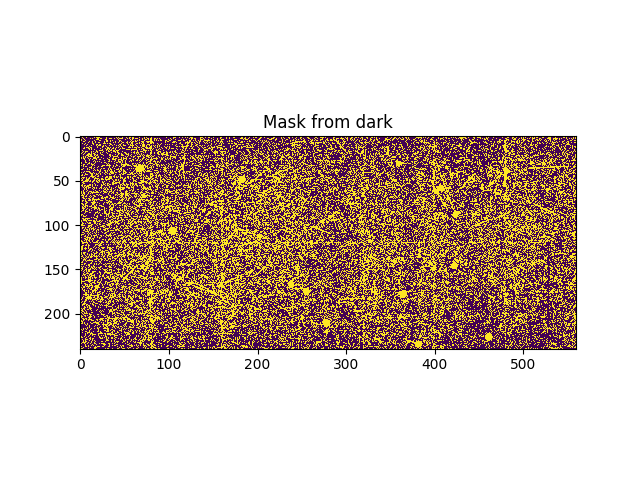

<IPython.core.display.Javascript object>


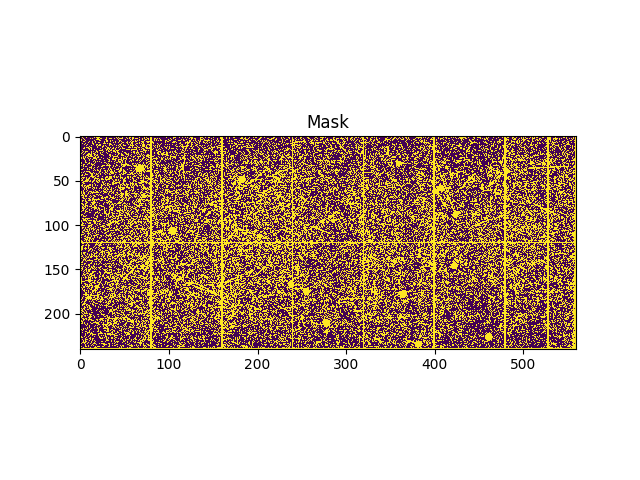

In [33]:
# create a bunch of function used to generate the mask

def mask_from_detector(detector: str) -> numpy.ndarray:
        det = detector_factory(detector)
        mask = det.calc_mask() ## int8
        
        # on a repere des discidents
        mask[:, 527:529] = 1
        mask[1, 413] = 1
        mask[3, 530] = 1
        mask[186, 333] = 1
        mask[233, 281] = 1
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask)
        ax.set_title("Detector mask")

        return mask
    
def mask_from_data(params: Calibration) -> numpy.ndarray:
    prod_threshold = 1
    always_threshold = 660
    
    with File(params.filename, mode='r') as h5file:
        images = get_dataset(h5file, params.images_path)[:].astype('double')
        
        # product and variance of all the images
        prod = images.prod(axis=0)
        var = images.var(axis=0)
        fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
        ax0 = ax[0]
        ax0.set_title('product of all the images (log)')
        ax0.imshow(numpy.log(prod+1.0))
        ax1 = ax[1]
        ax1.set_title('variance of all the images')
        ax1.imshow(numpy.log(var+1.0))

        # remove the non counting pixels
        mask_non_counting = numpy.where(prod < prod_threshold, 1, 0).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_non_counting)
        ax.set_title("Non counting pixels")
        
        # remove the inf values
        mask_inf = numpy.isinf(prod).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_inf)
        ax.set_title("Inf values")

        mask = mask_non_counting.copy()
        mask = numpy.logical_or(mask, mask_inf)
        
        return mask

def mask_from_flat(detector: str,
                   flat: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(flat < 1, 1, 0).astype('int8')
        mask = numpy.logical_or(mask, numpy.where(flat > 20, 1, 0))

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from flat")
        
    return mask

def mask_from_dark(detector: str,
                   dark: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(dark != 0, 1, 0).astype('int8')

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from dark")
        
    return mask

mask = mask_from_detector(params.detector)
mask = numpy.logical_or(mask, mask_from_data(params))
mask = numpy.logical_or(mask, mask_from_flat(params.detector, flat))
mask = numpy.logical_or(mask, mask_from_dark(params.detector, dark))

fig, ax = pylab.subplots(1, 1, sharex=True, sharey=True)
ax.imshow(mask)
ax.set_title('Mask')

## Integration <a name="integration"></a>

<IPython.core.display.Javascript object>


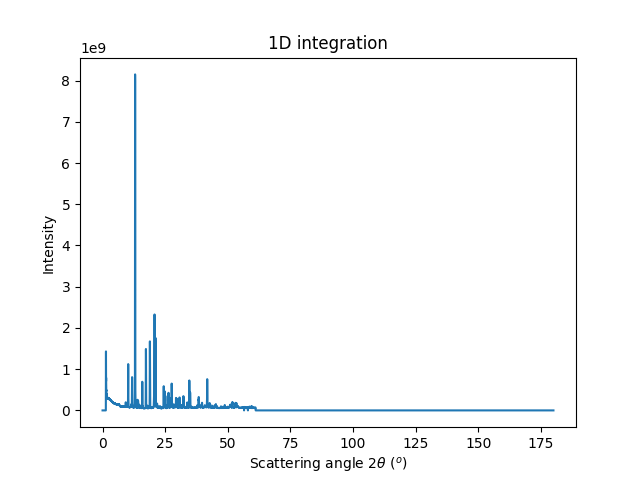

<IPython.core.display.Javascript object>


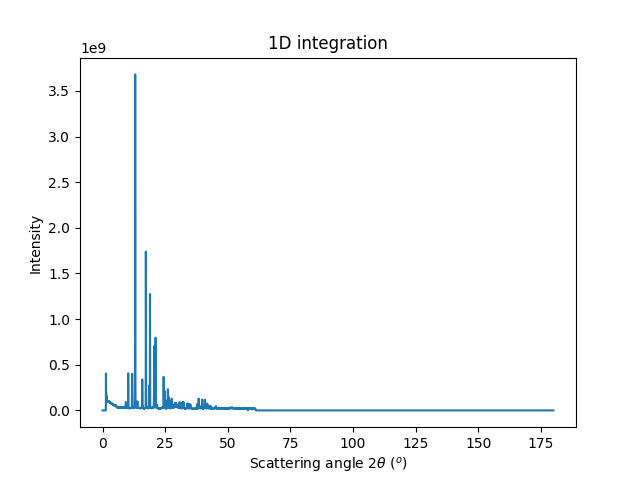

<IPython.core.display.Javascript object>


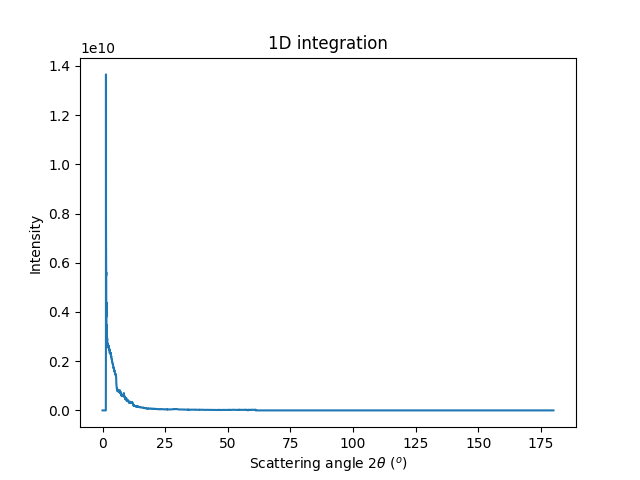

<IPython.core.display.Javascript object>


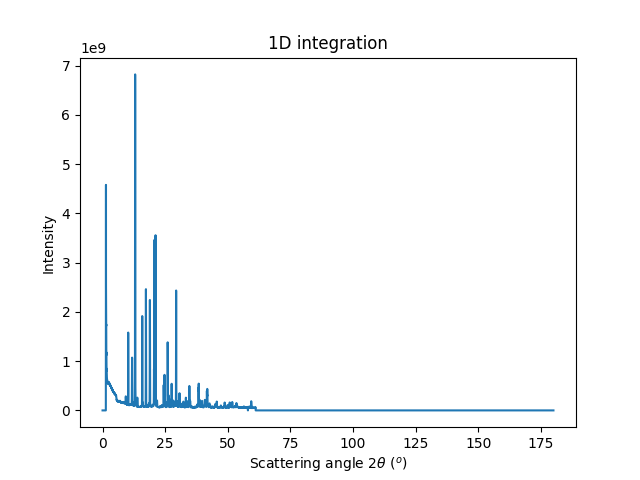

<IPython.core.display.Javascript object>


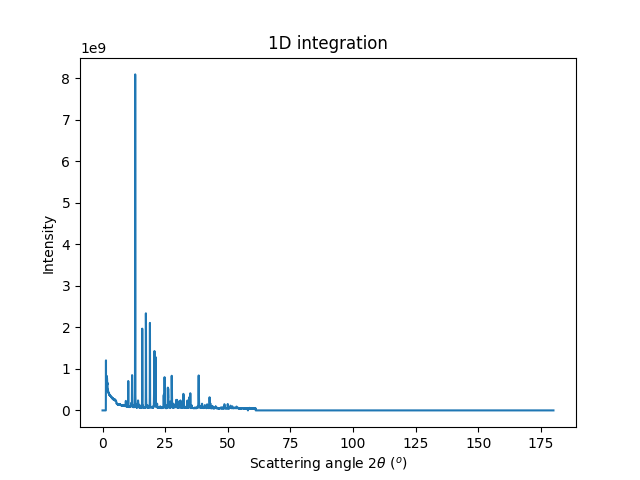

<IPython.core.display.Javascript object>


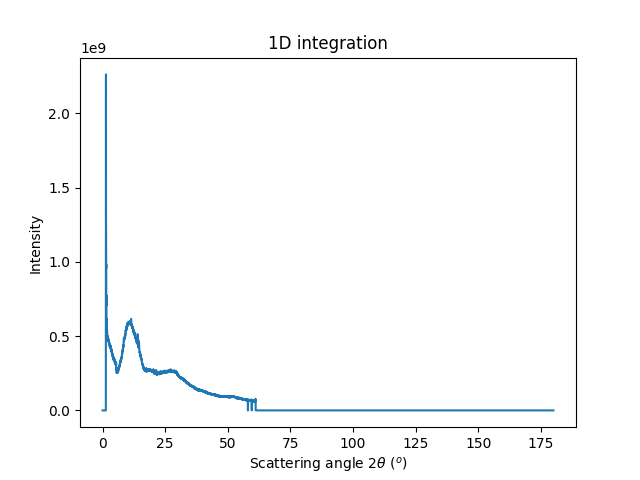

<IPython.core.display.Javascript object>


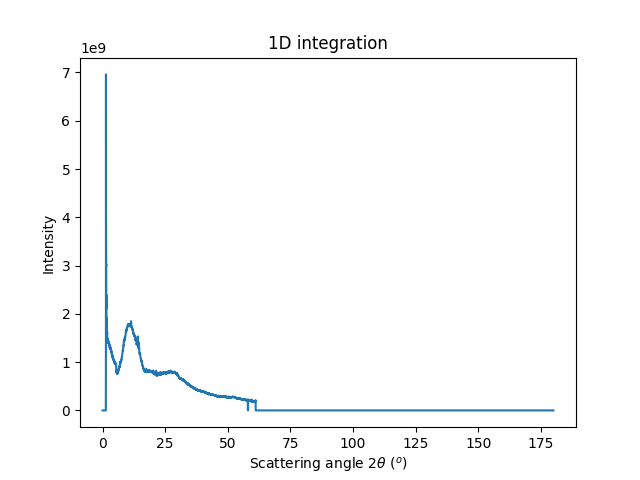

<IPython.core.display.Javascript object>


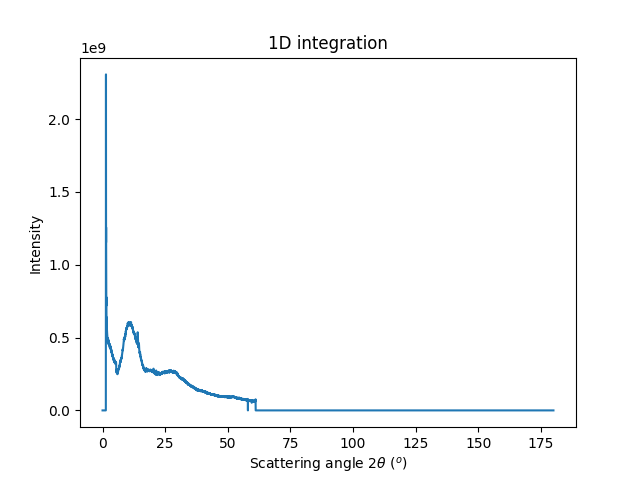

<IPython.core.display.Javascript object>


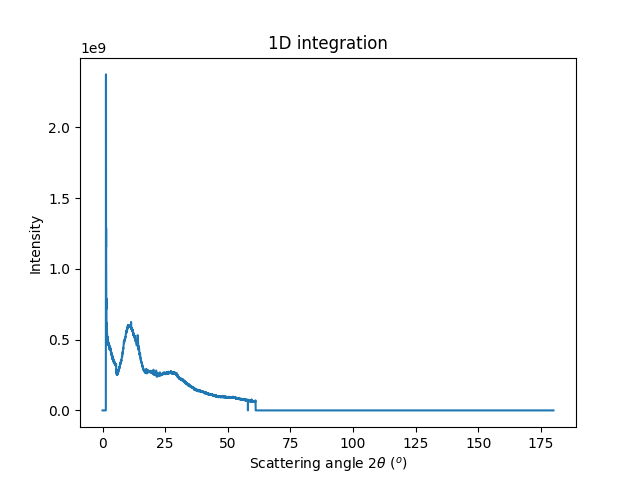

<IPython.core.display.Javascript object>


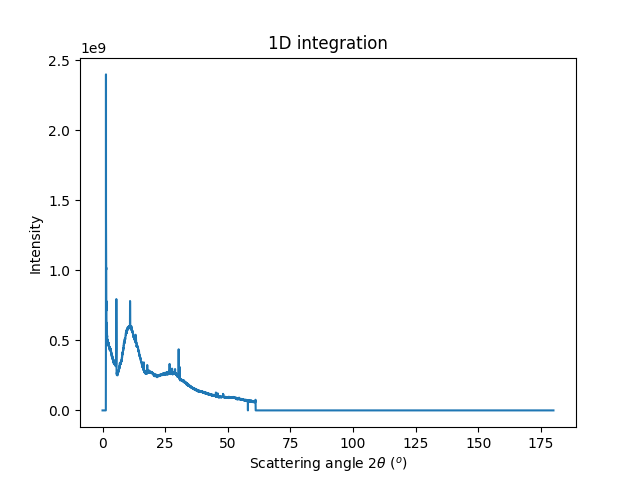

<IPython.core.display.Javascript object>


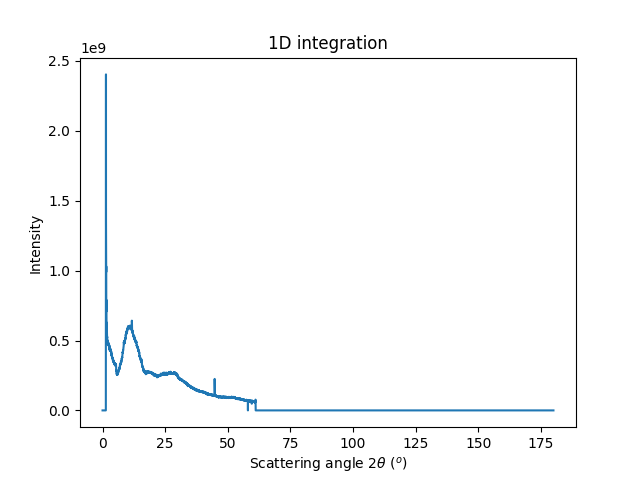

<IPython.core.display.Javascript object>


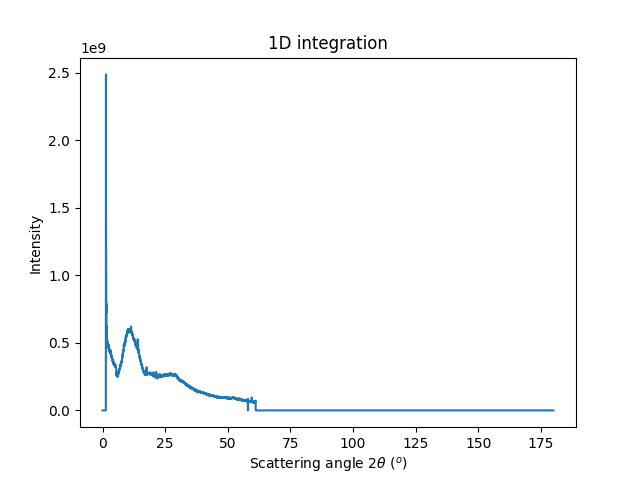

<IPython.core.display.Javascript object>


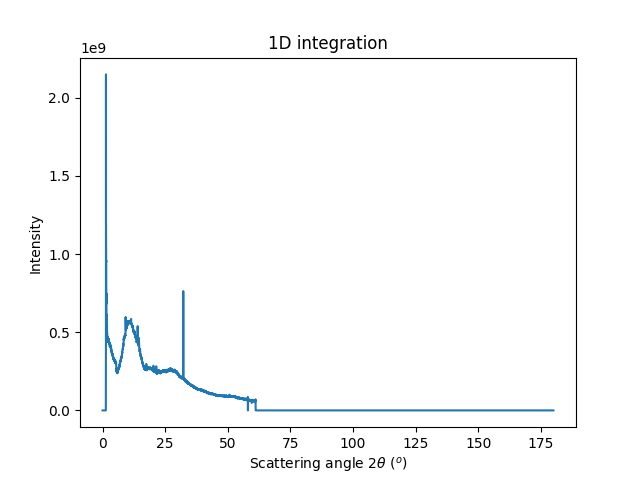

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


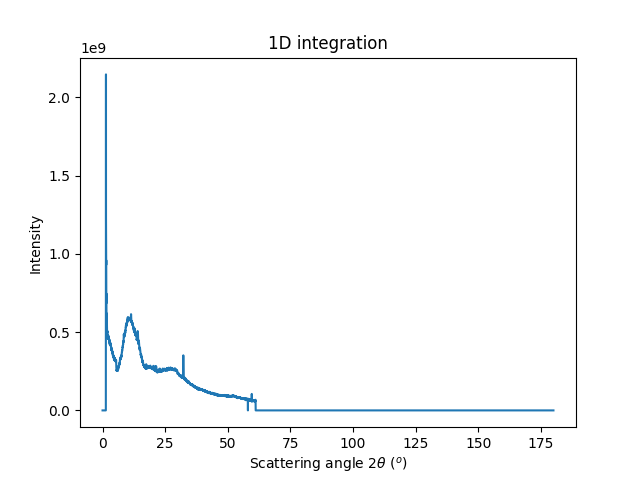

<IPython.core.display.Javascript object>


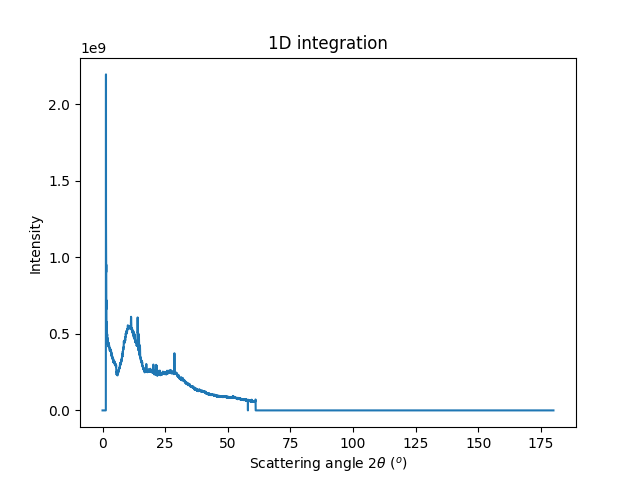

<IPython.core.display.Javascript object>


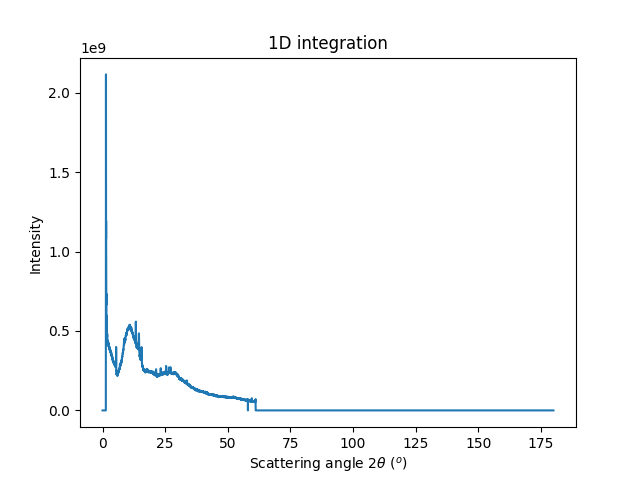

<IPython.core.display.Javascript object>


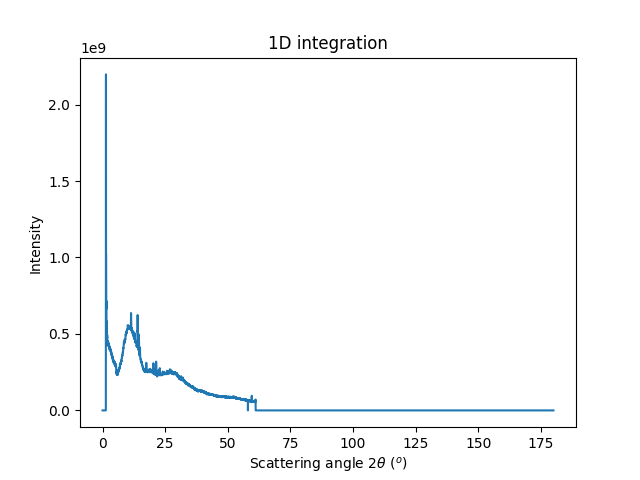

<IPython.core.display.Javascript object>


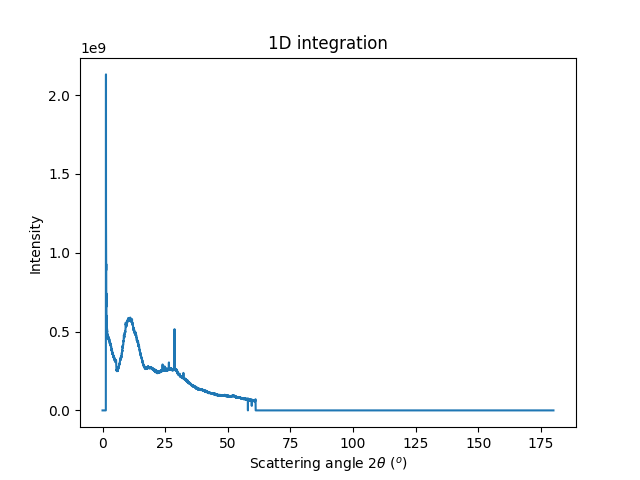

<IPython.core.display.Javascript object>


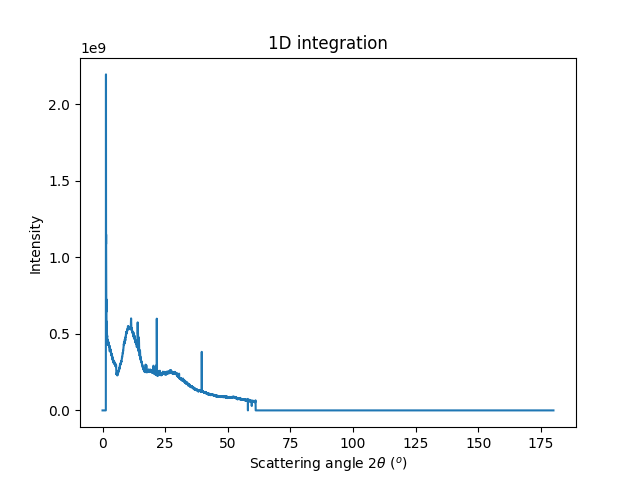

<IPython.core.display.Javascript object>


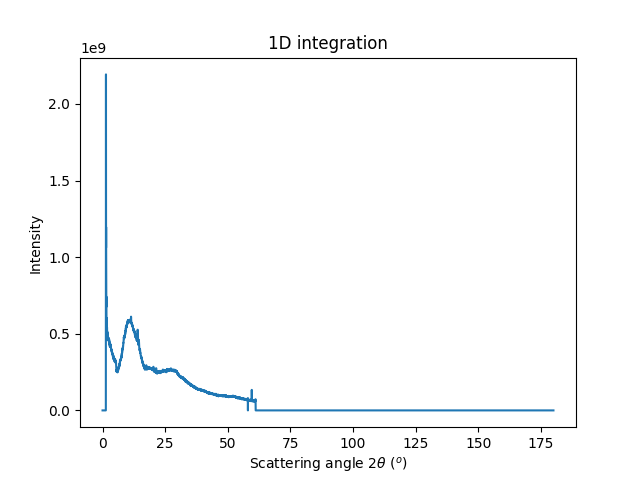

<IPython.core.display.Javascript object>


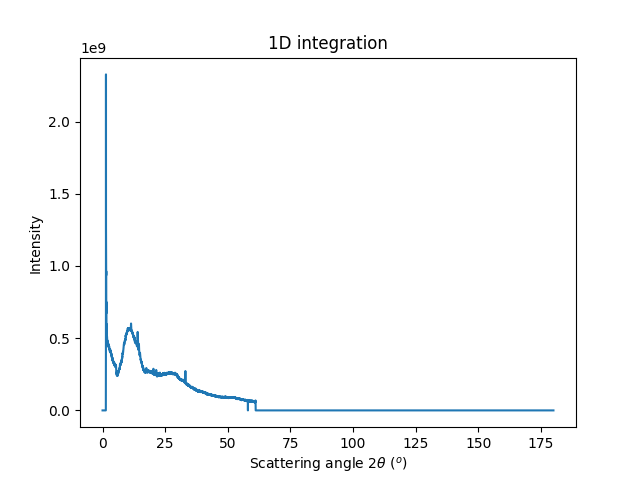

<IPython.core.display.Javascript object>


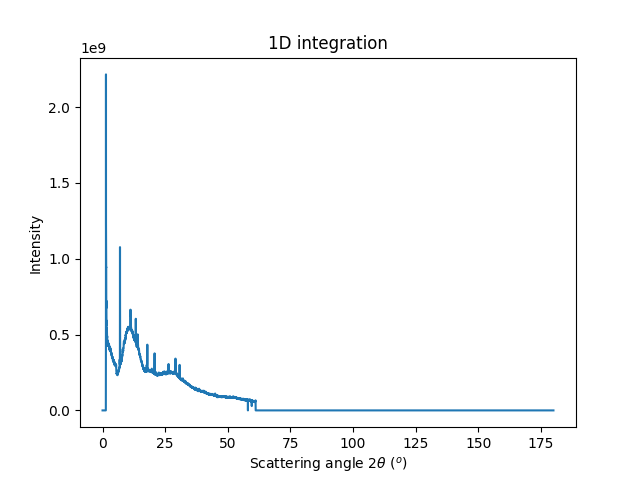

<IPython.core.display.Javascript object>


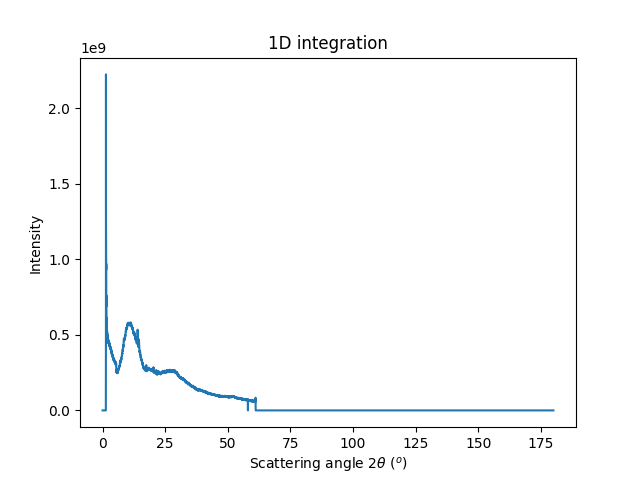

<IPython.core.display.Javascript object>


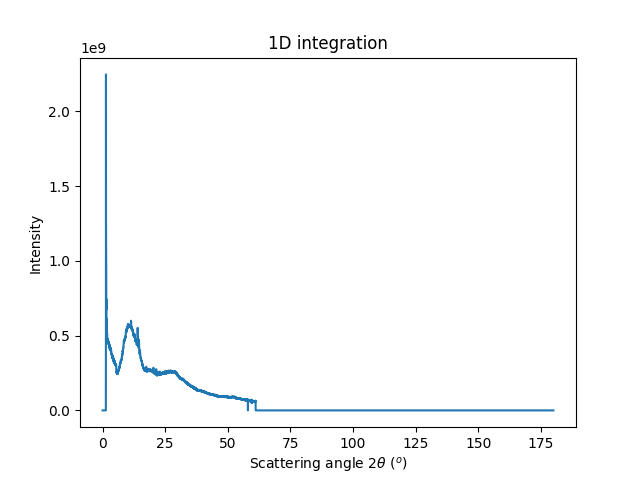

<IPython.core.display.Javascript object>


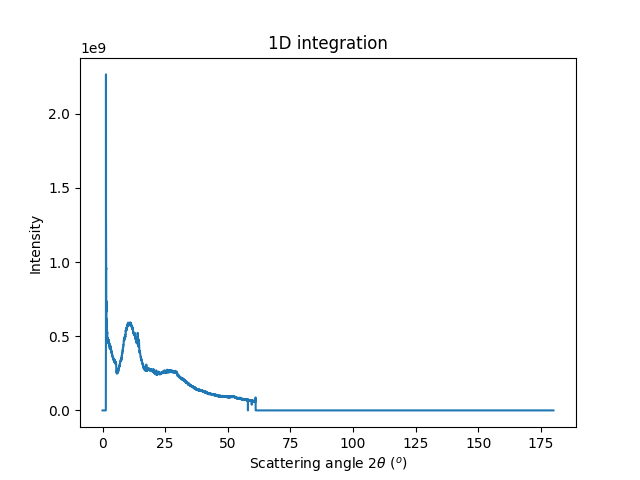

<IPython.core.display.Javascript object>


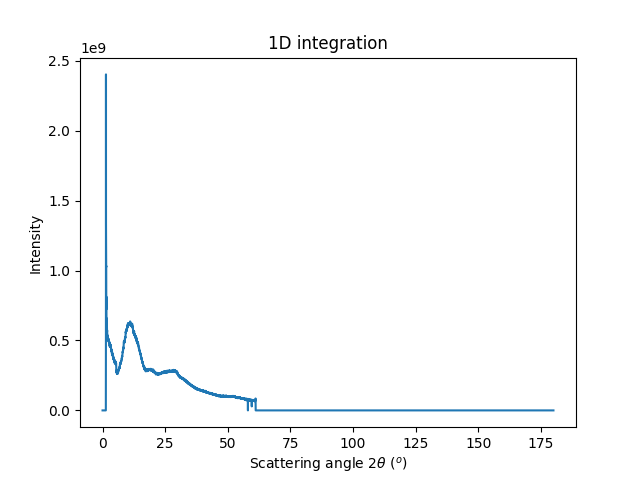

<IPython.core.display.Javascript object>


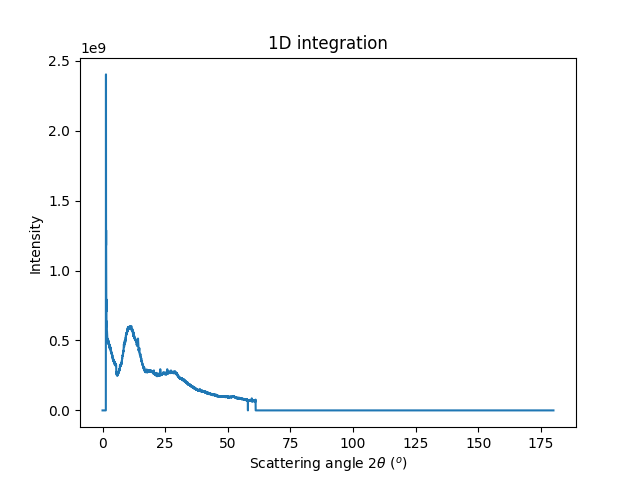

<IPython.core.display.Javascript object>


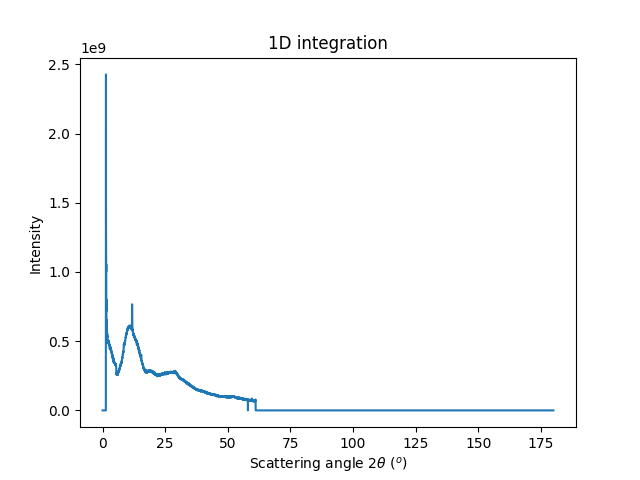

<IPython.core.display.Javascript object>


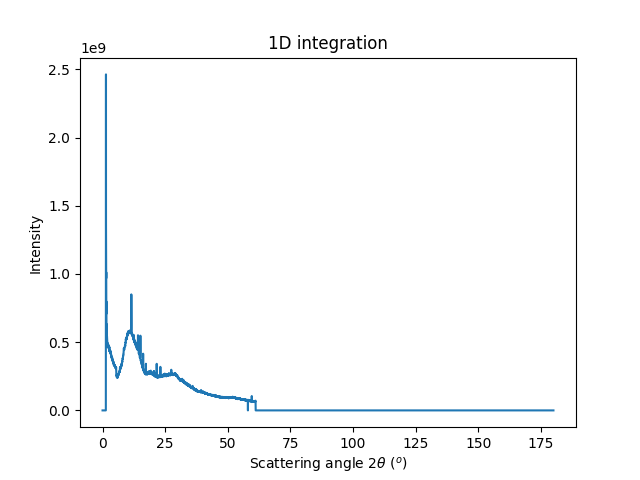

<IPython.core.display.Javascript object>


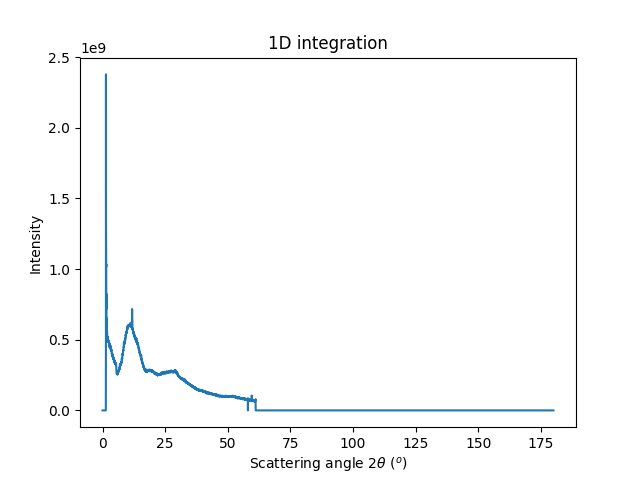

<IPython.core.display.Javascript object>


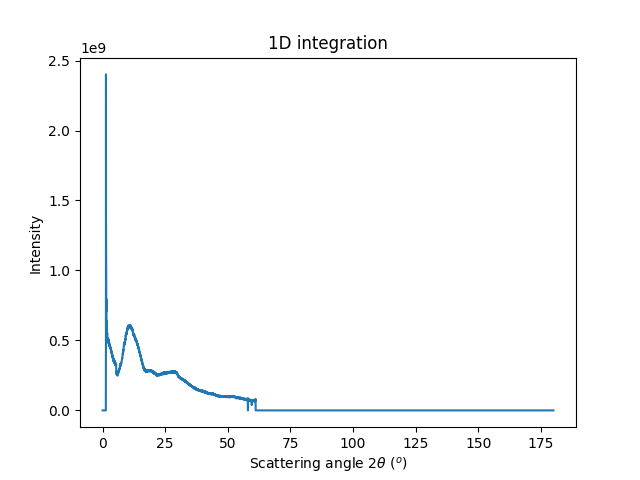

<IPython.core.display.Javascript object>


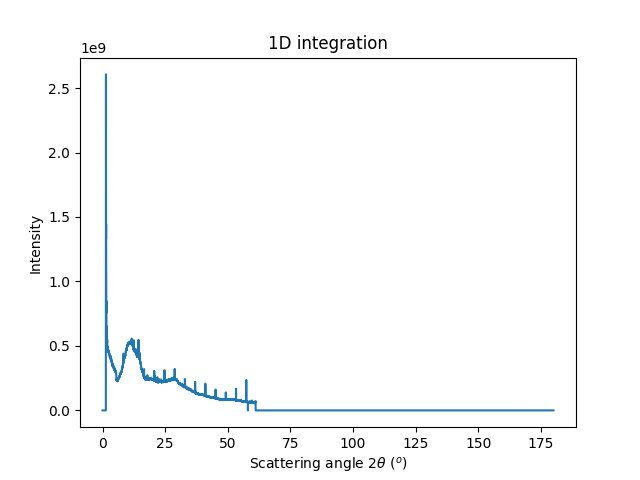

<IPython.core.display.Javascript object>


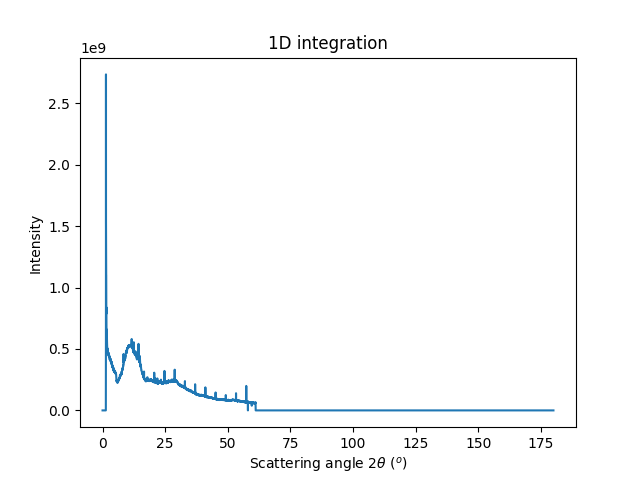

<IPython.core.display.Javascript object>


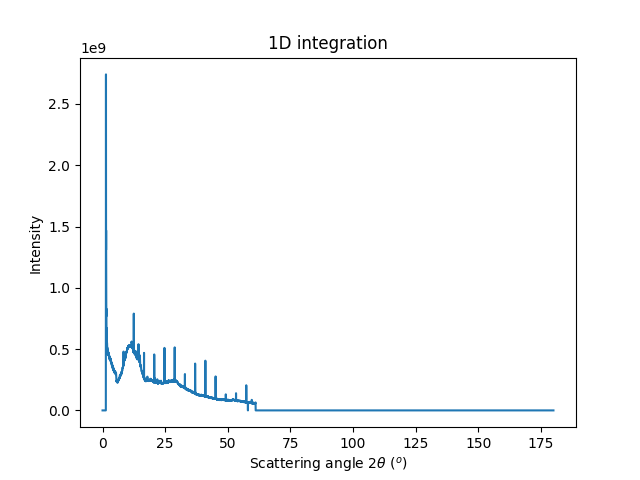

<IPython.core.display.Javascript object>


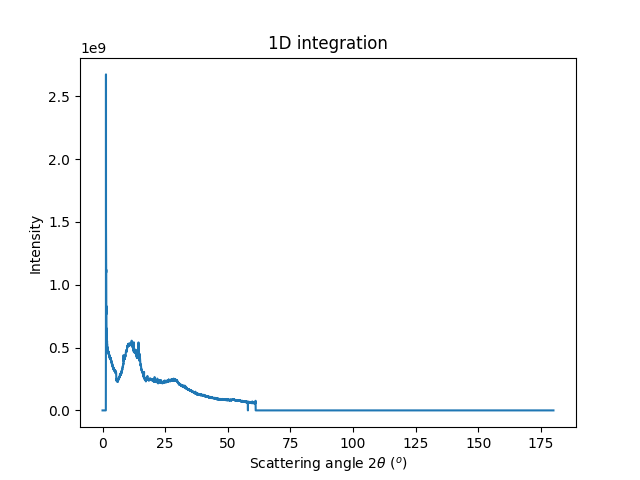

<IPython.core.display.Javascript object>


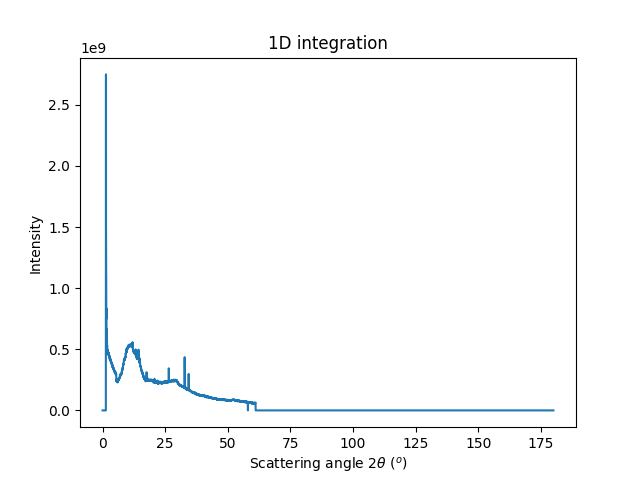

<IPython.core.display.Javascript object>


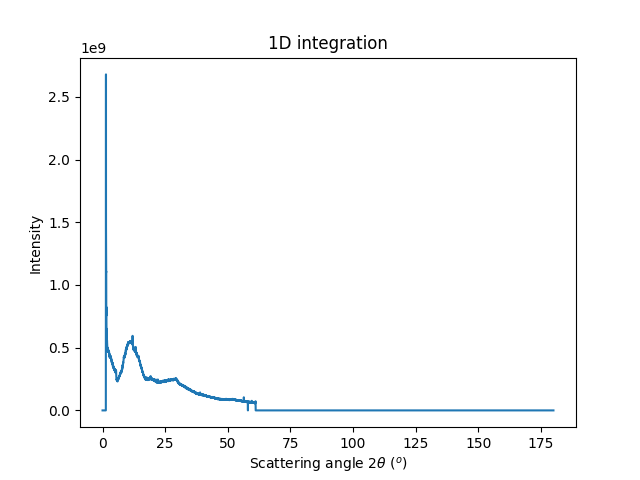

<IPython.core.display.Javascript object>


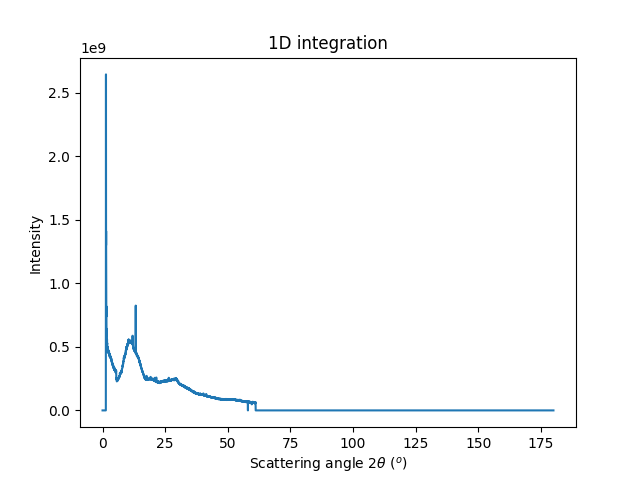

<IPython.core.display.Javascript object>


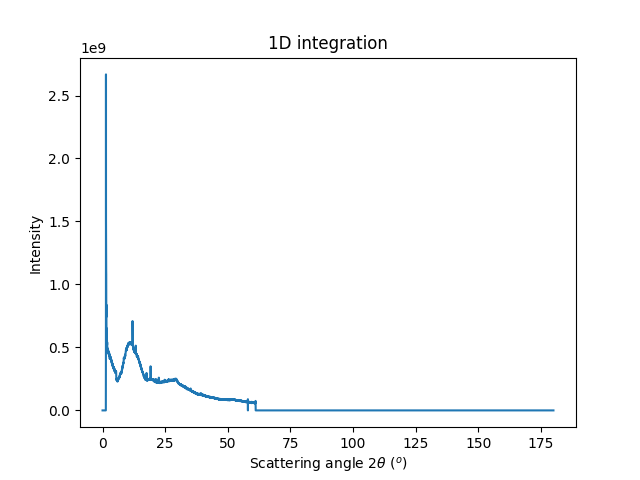

<IPython.core.display.Javascript object>


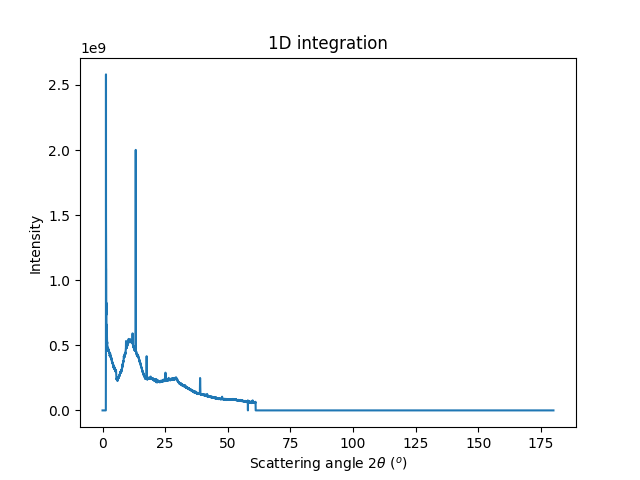

<IPython.core.display.Javascript object>


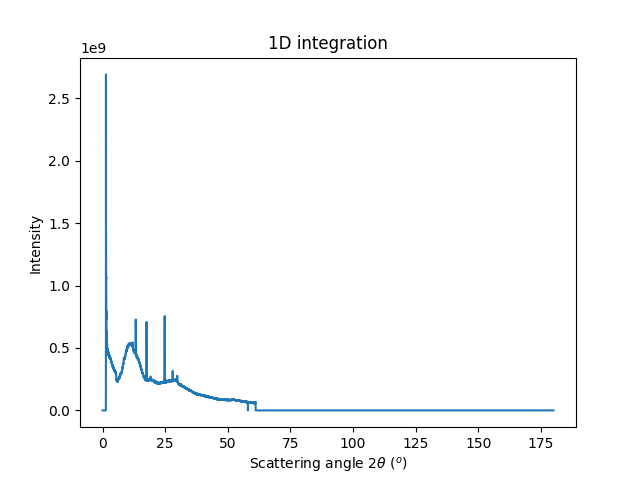

<IPython.core.display.Javascript object>


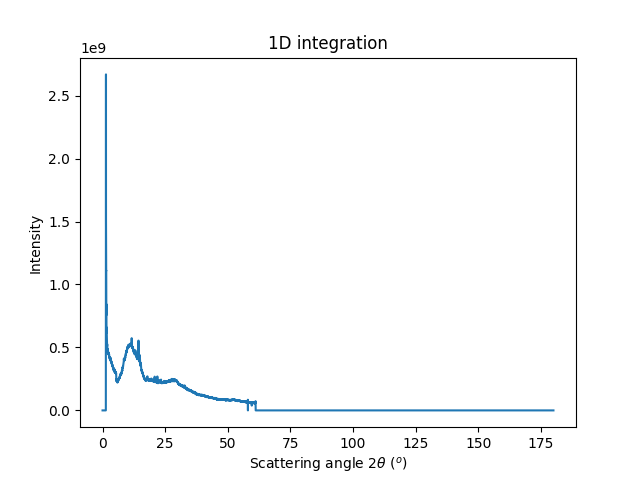

<IPython.core.display.Javascript object>


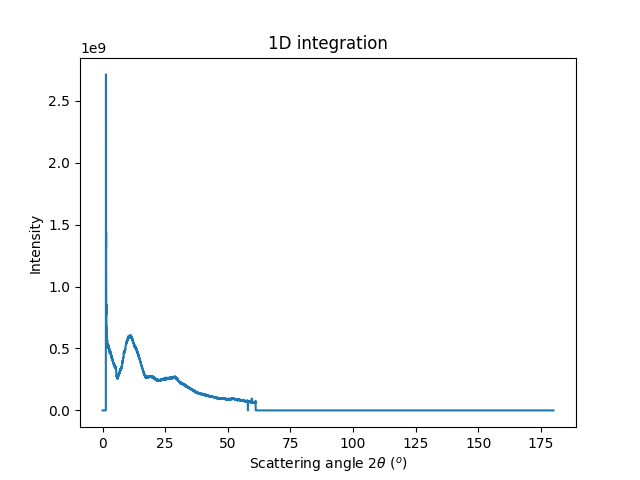

<IPython.core.display.Javascript object>


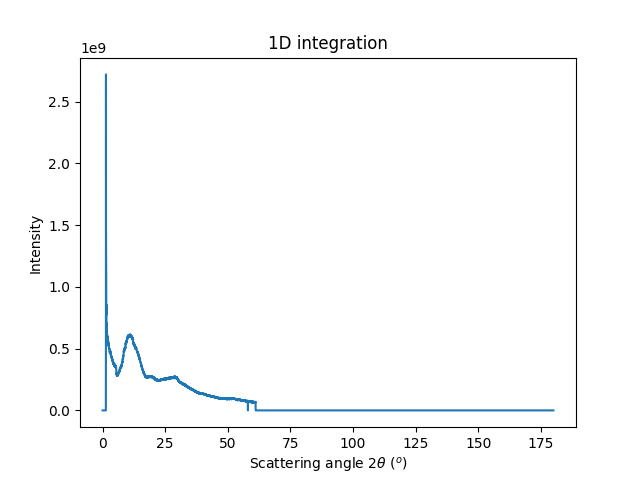

<IPython.core.display.Javascript object>


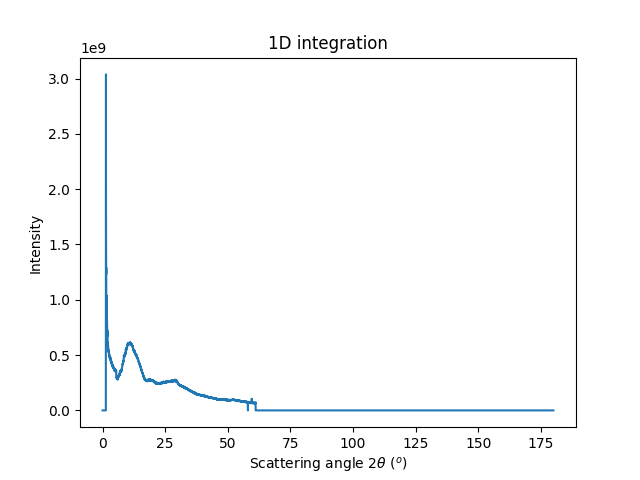

<IPython.core.display.Javascript object>


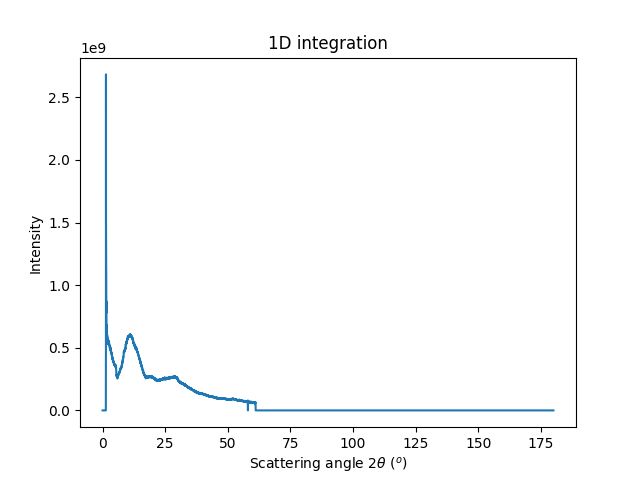

<IPython.core.display.Javascript object>


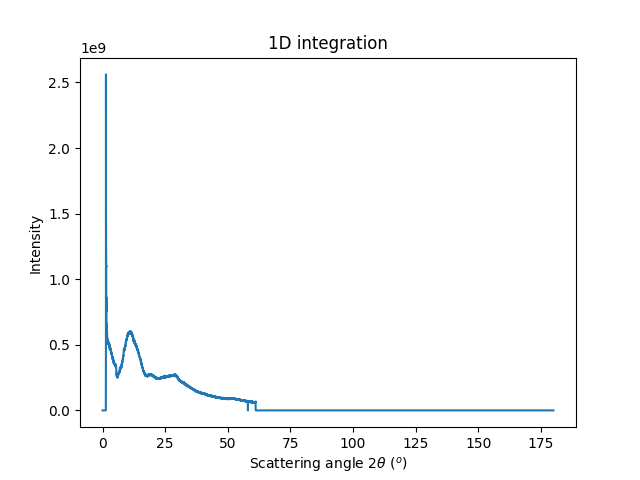

<IPython.core.display.Javascript object>


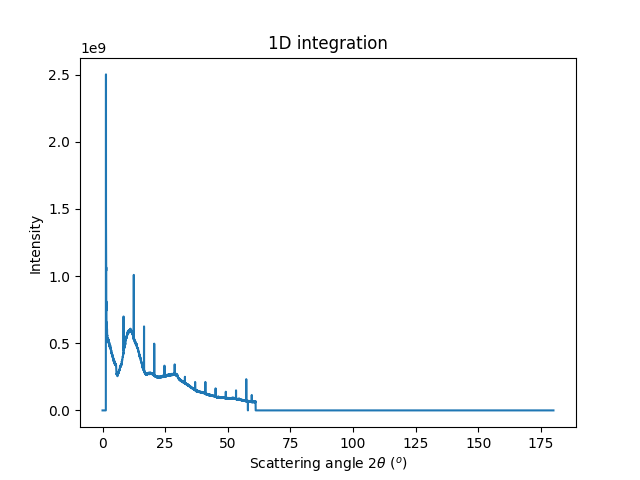

<IPython.core.display.Javascript object>


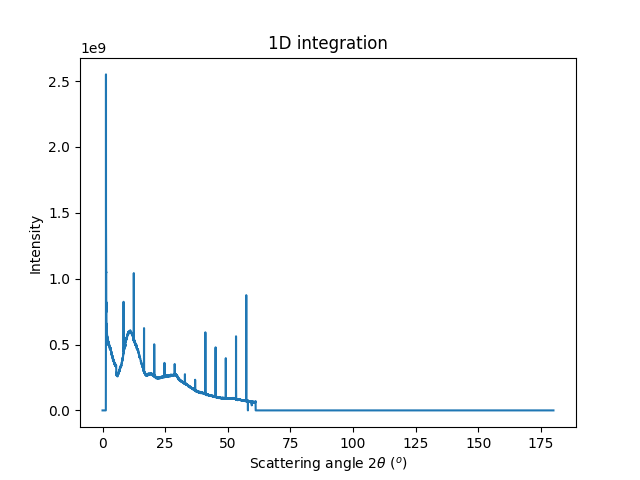

<IPython.core.display.Javascript object>


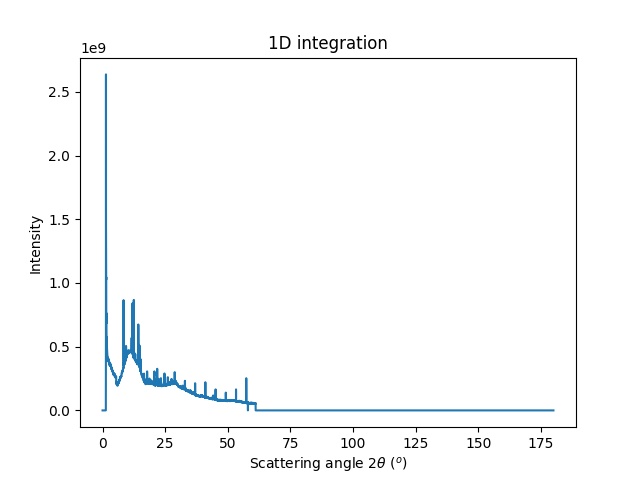

<IPython.core.display.Javascript object>


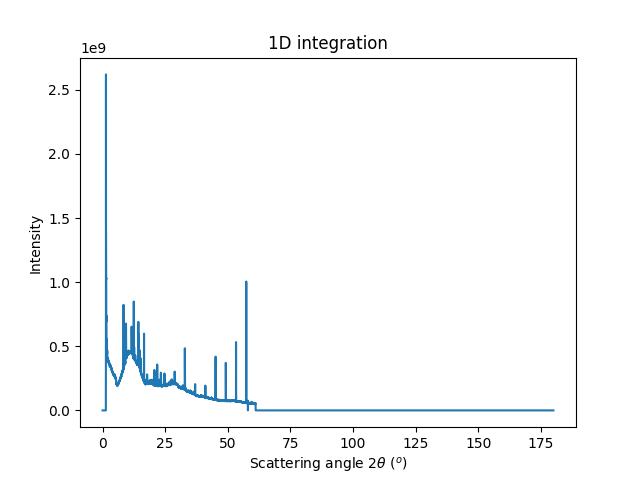

<IPython.core.display.Javascript object>


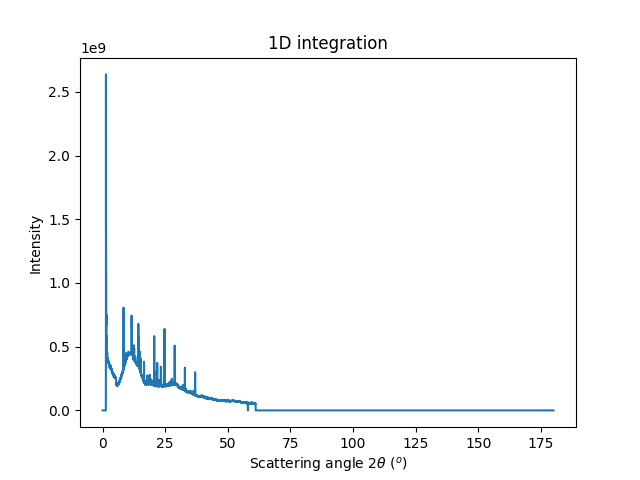

<IPython.core.display.Javascript object>


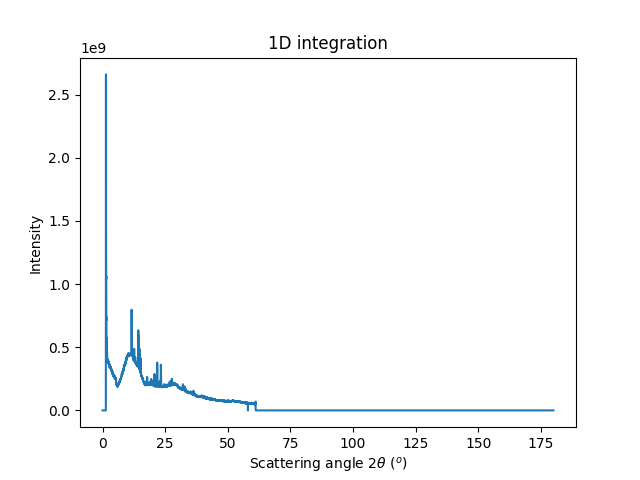

<IPython.core.display.Javascript object>


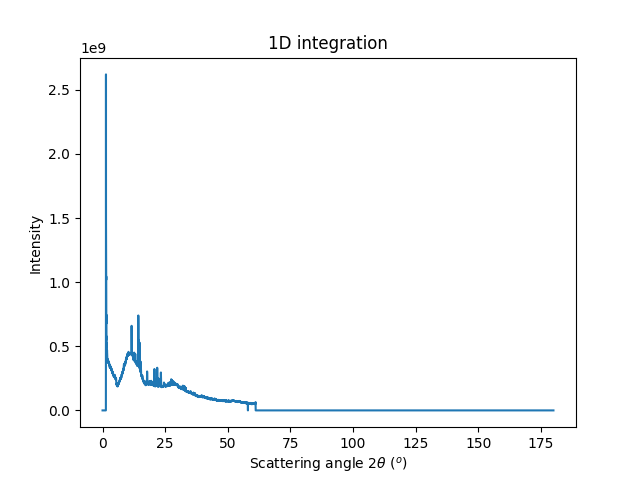

<IPython.core.display.Javascript object>


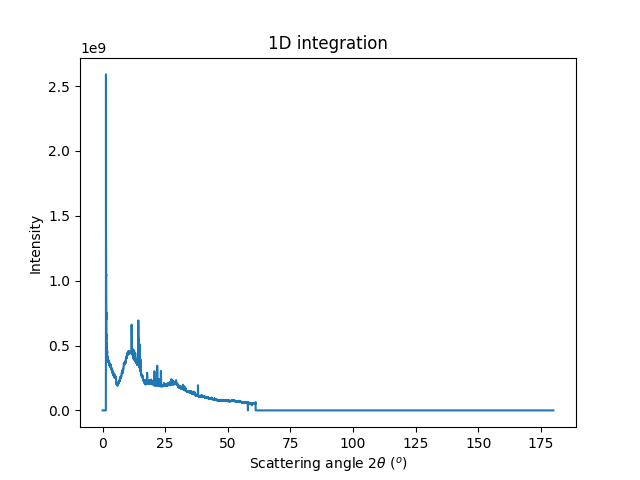

<IPython.core.display.Javascript object>


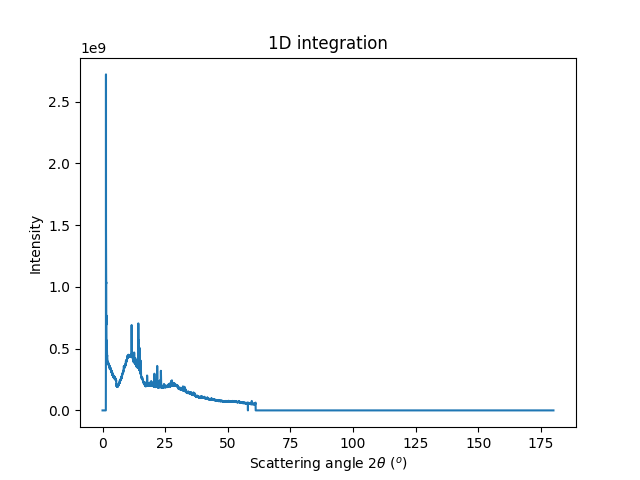

<IPython.core.display.Javascript object>


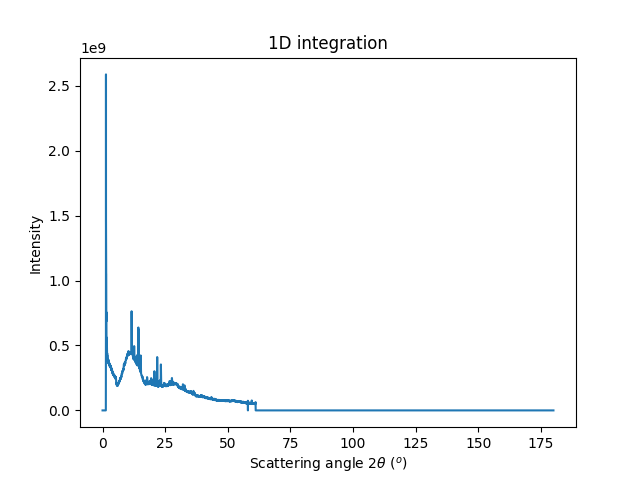

<IPython.core.display.Javascript object>


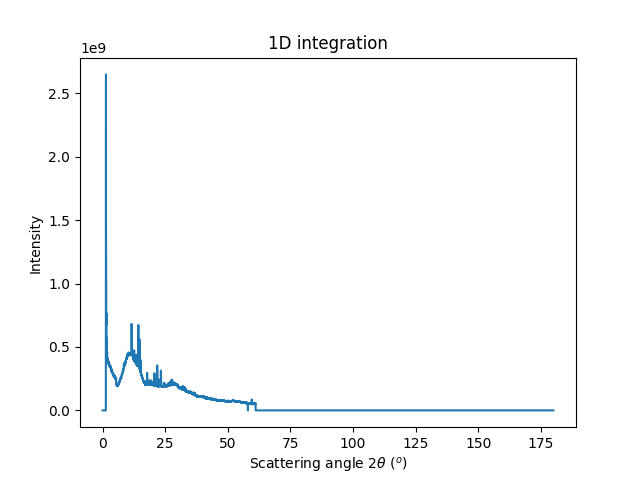

<IPython.core.display.Javascript object>


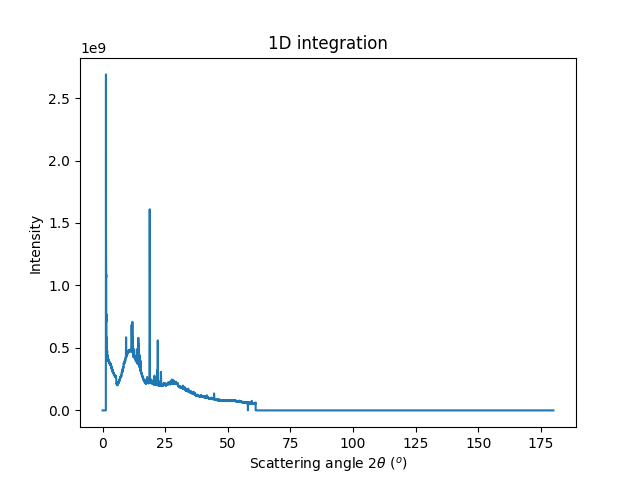

<IPython.core.display.Javascript object>


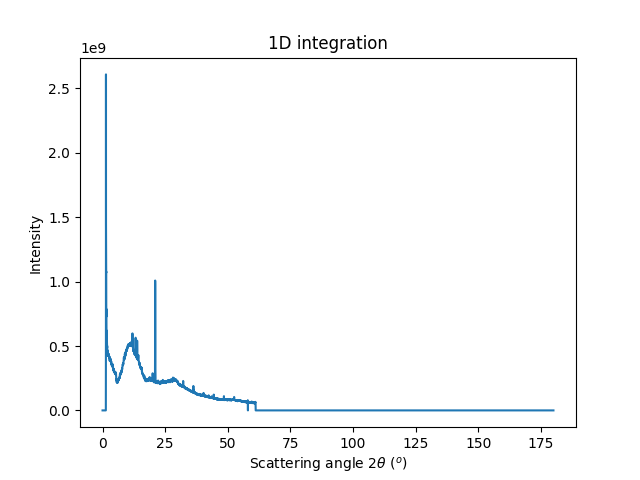

<IPython.core.display.Javascript object>


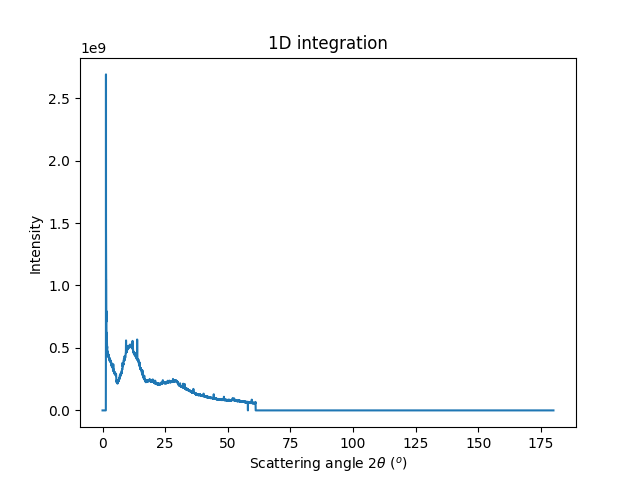

<IPython.core.display.Javascript object>


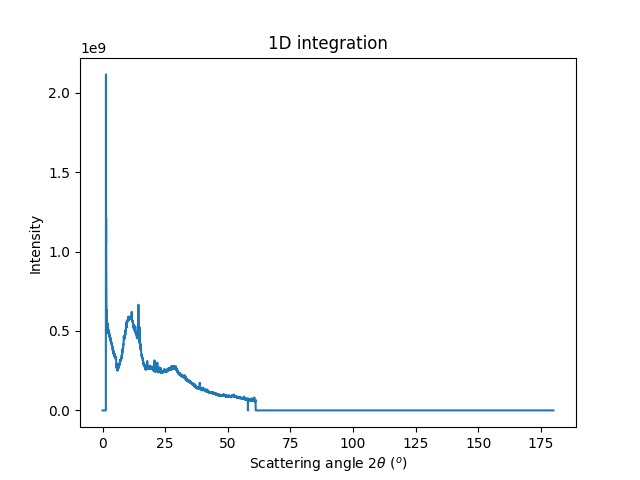

<IPython.core.display.Javascript object>


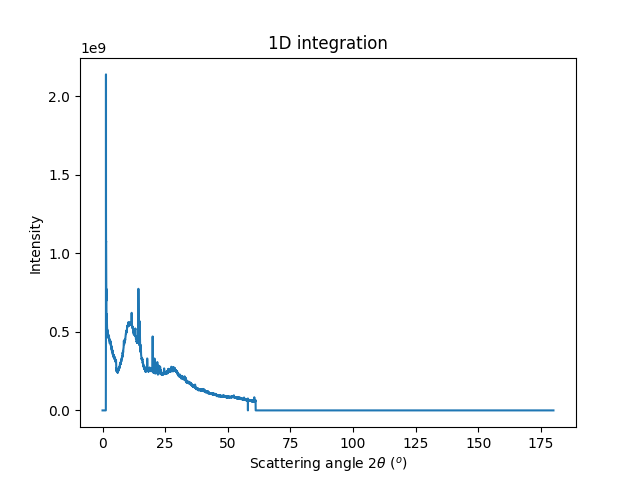

<IPython.core.display.Javascript object>


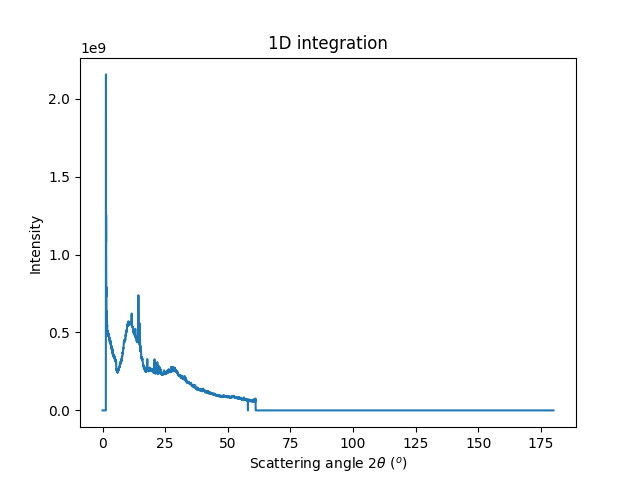

<IPython.core.display.Javascript object>


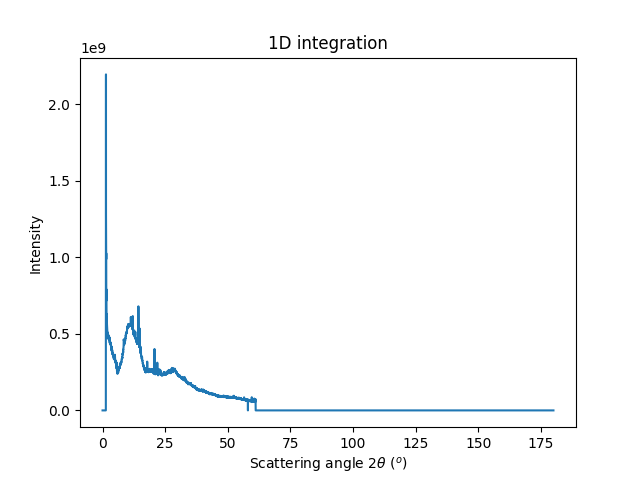

<IPython.core.display.Javascript object>


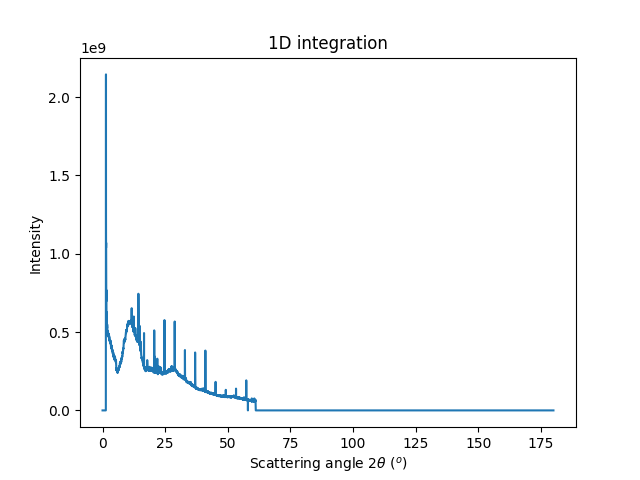

<IPython.core.display.Javascript object>


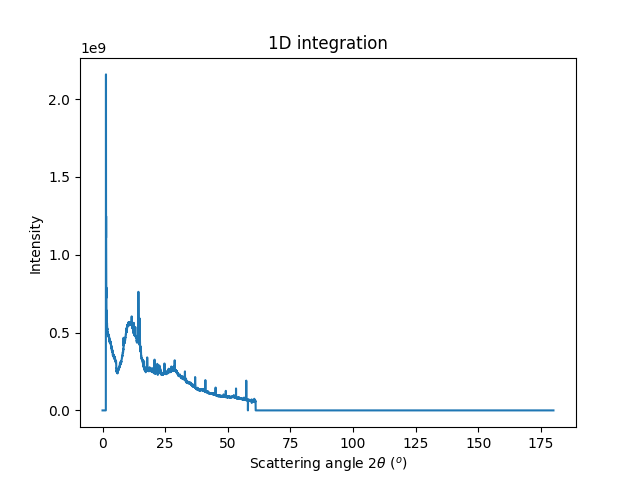

<IPython.core.display.Javascript object>


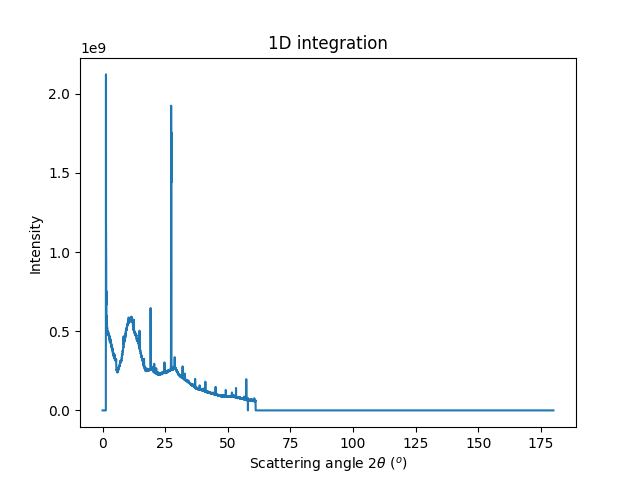

<IPython.core.display.Javascript object>


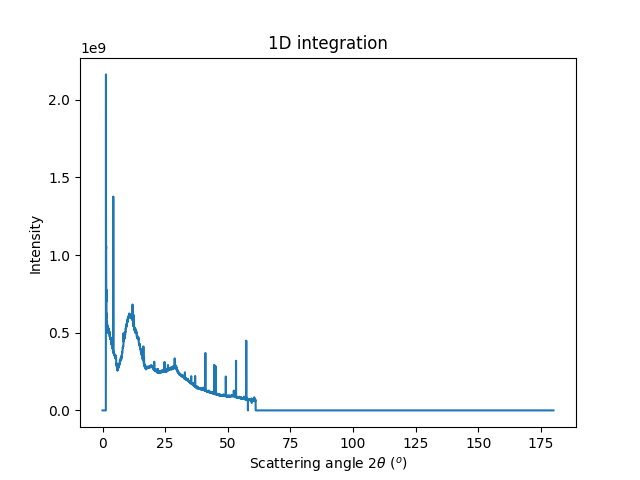

<IPython.core.display.Javascript object>


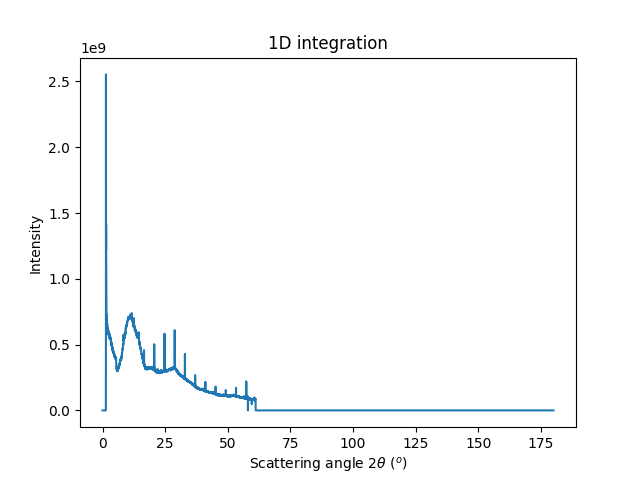

<IPython.core.display.Javascript object>


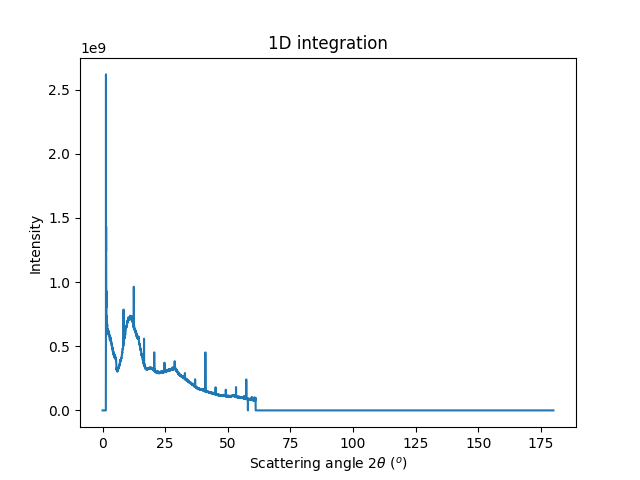

<IPython.core.display.Javascript object>


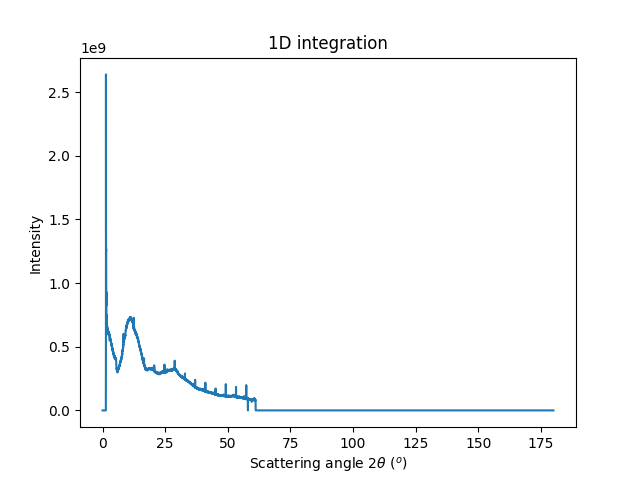

<IPython.core.display.Javascript object>


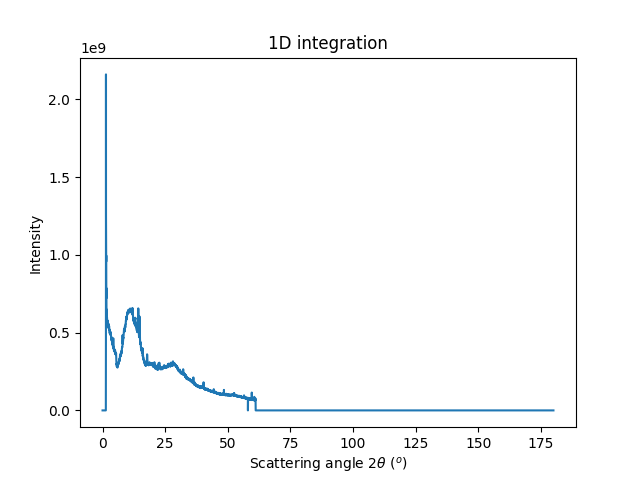

<IPython.core.display.Javascript object>


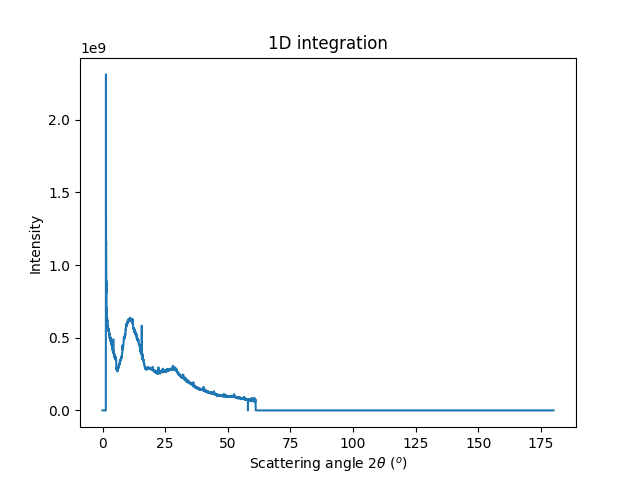

<IPython.core.display.Javascript object>


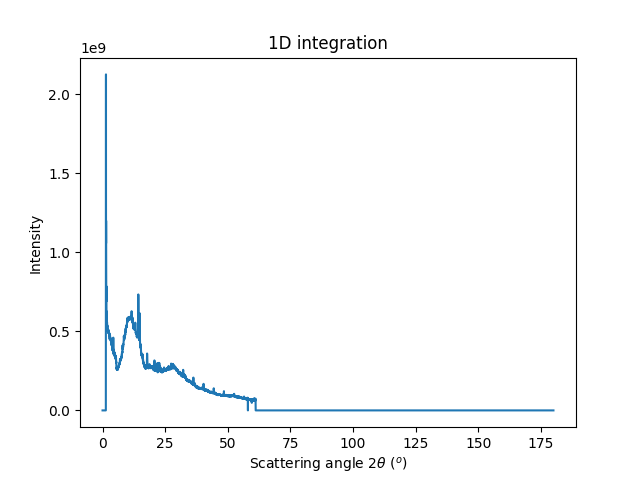

<IPython.core.display.Javascript object>


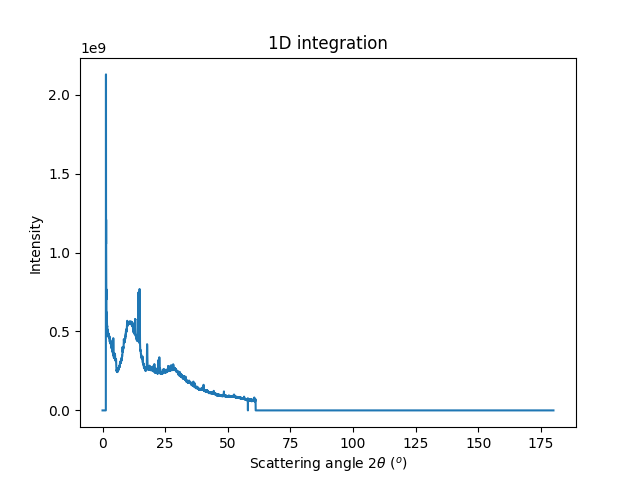

<IPython.core.display.Javascript object>


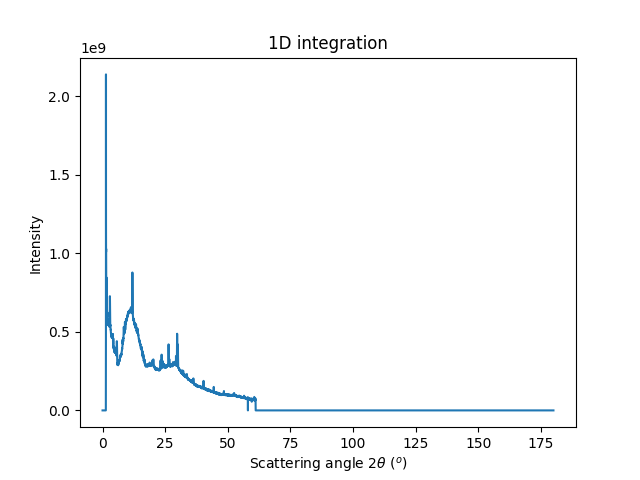

<IPython.core.display.Javascript object>


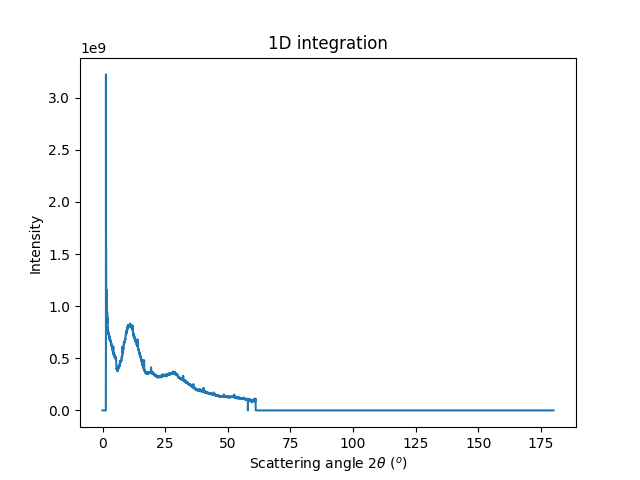

<IPython.core.display.Javascript object>


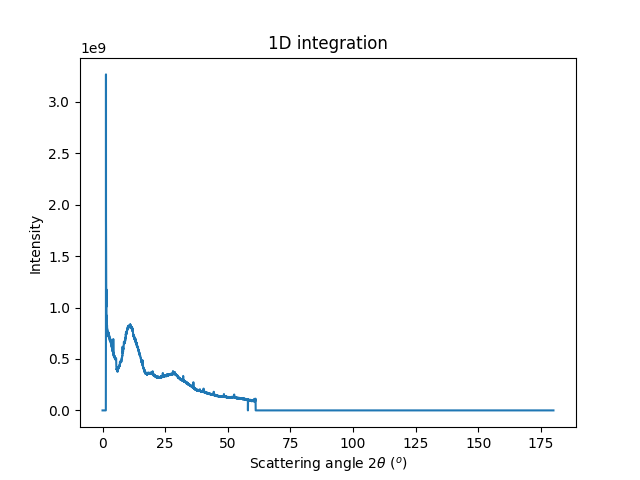

<IPython.core.display.Javascript object>


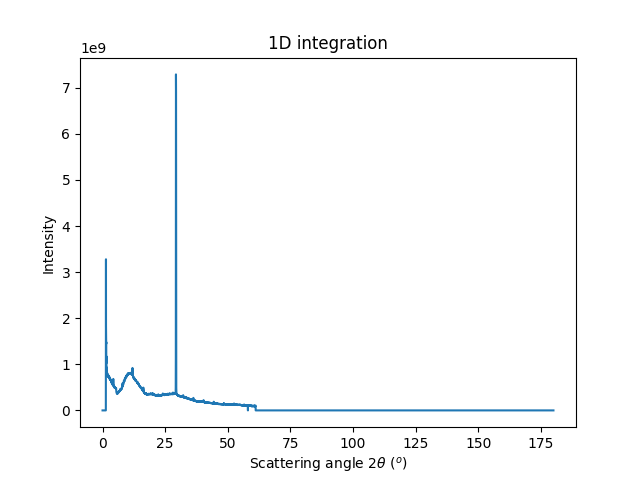

<IPython.core.display.Javascript object>


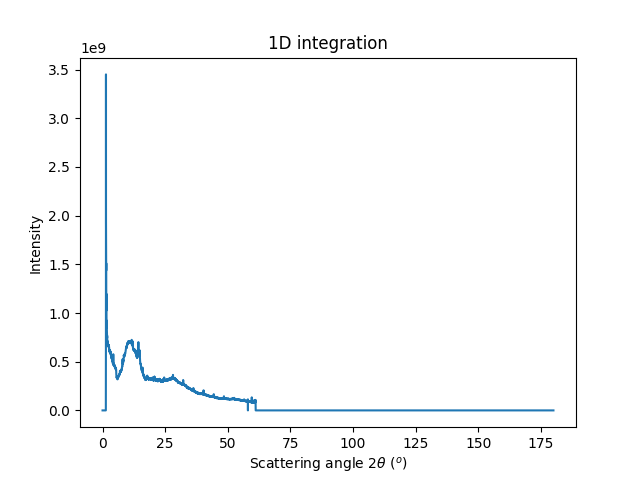

<IPython.core.display.Javascript object>


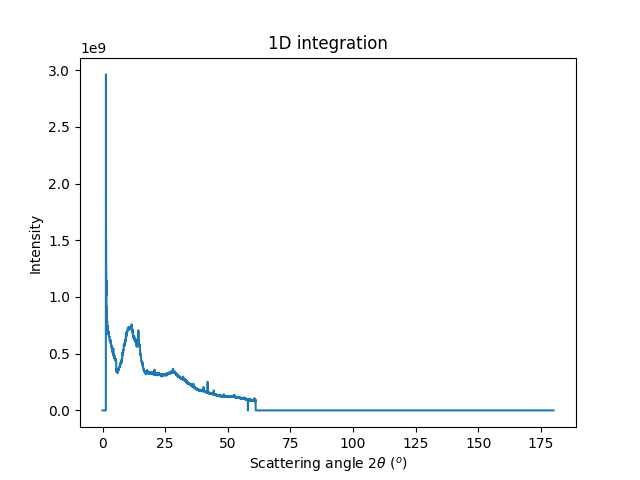

<IPython.core.display.Javascript object>


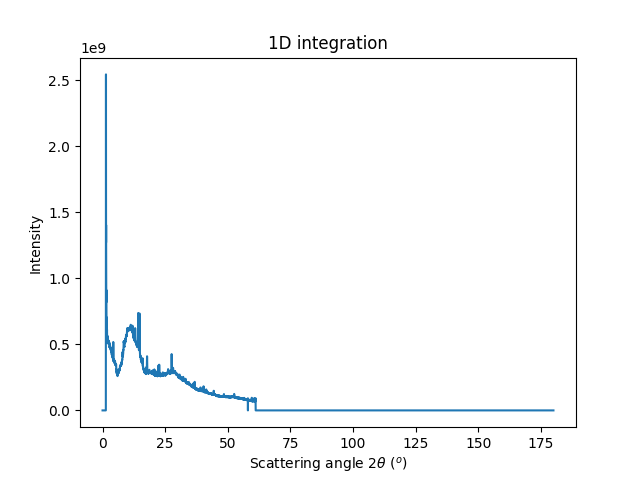

<IPython.core.display.Javascript object>


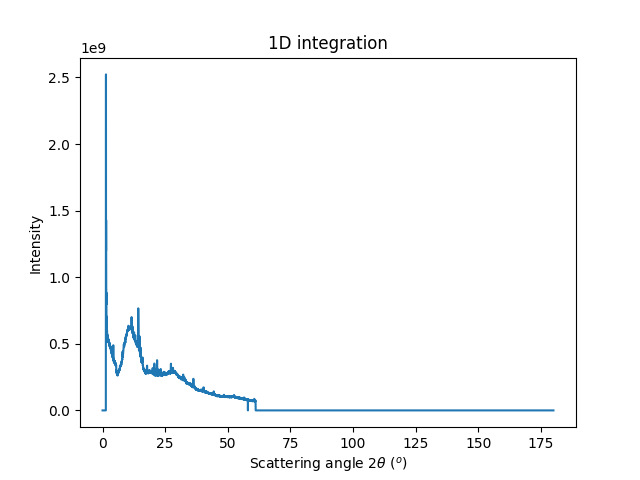

<IPython.core.display.Javascript object>


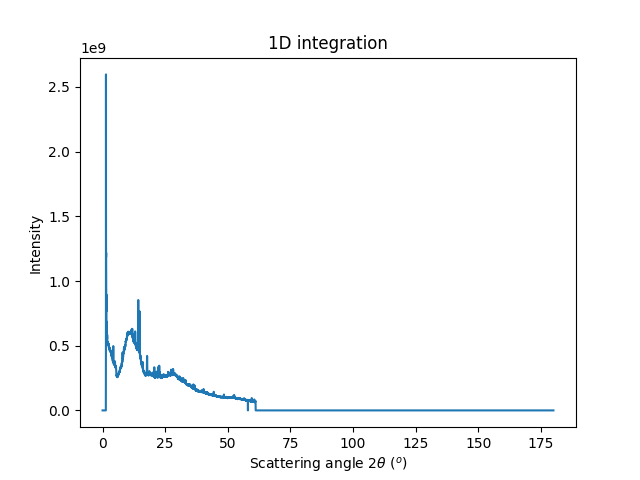

<IPython.core.display.Javascript object>


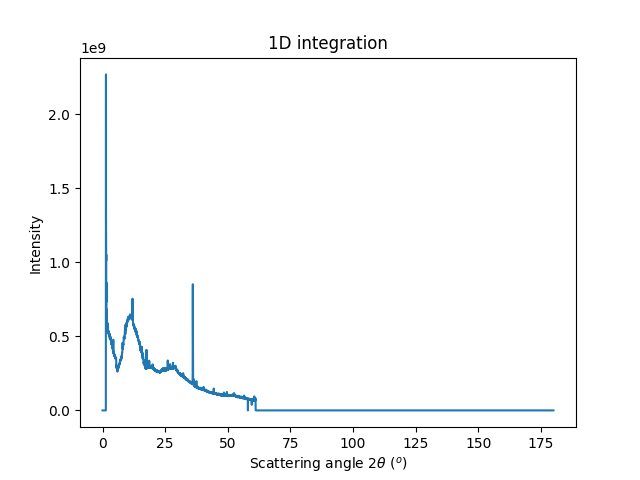

<IPython.core.display.Javascript object>


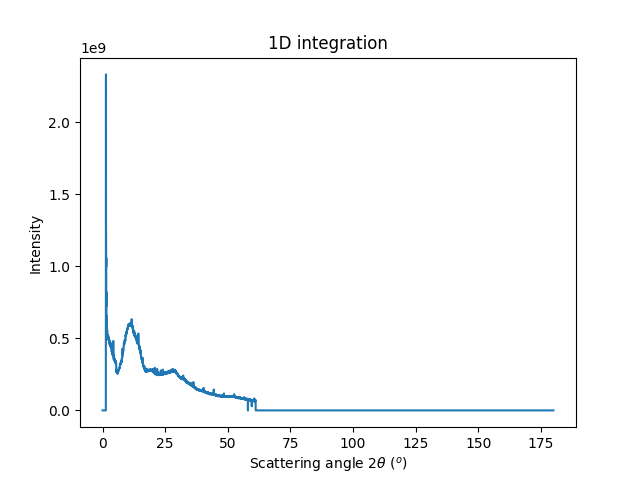

<IPython.core.display.Javascript object>


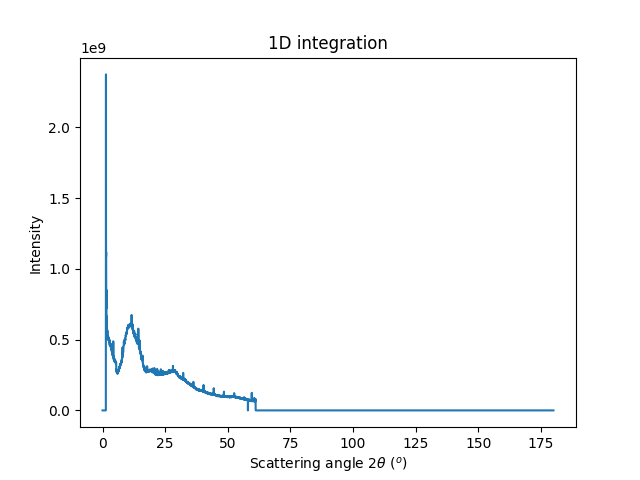

<IPython.core.display.Javascript object>


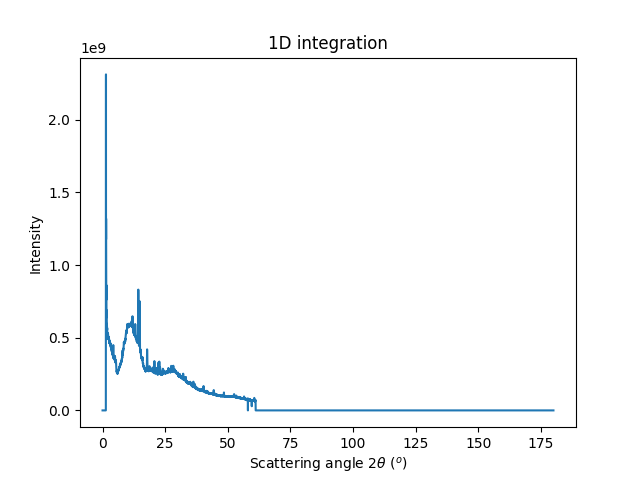

<IPython.core.display.Javascript object>


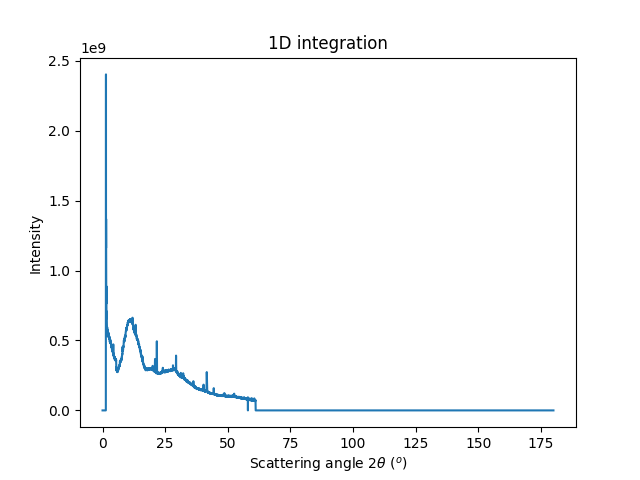

<IPython.core.display.Javascript object>


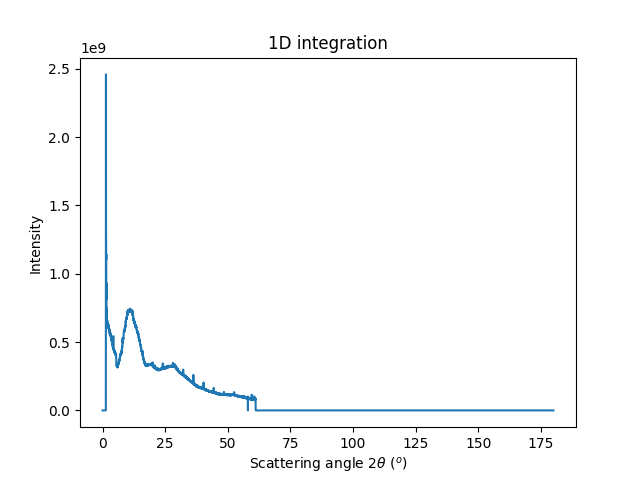

<IPython.core.display.Javascript object>


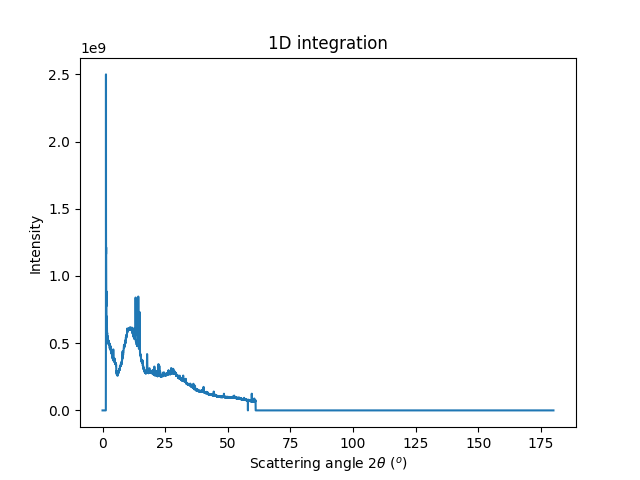

<IPython.core.display.Javascript object>


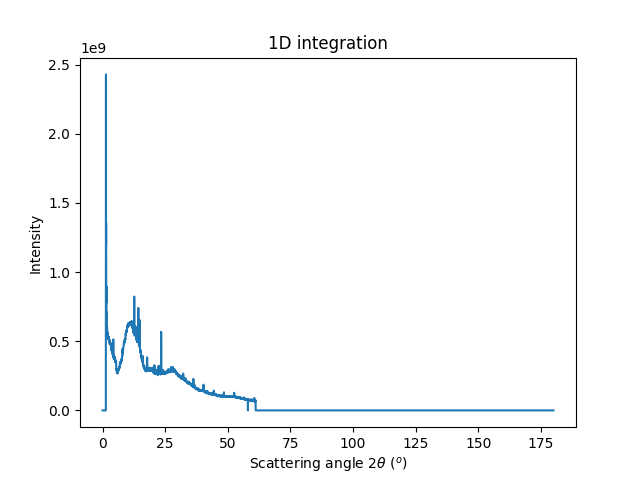

<IPython.core.display.Javascript object>


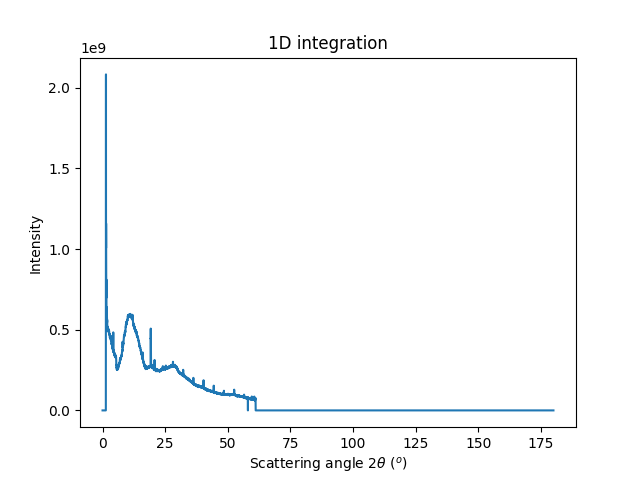

<IPython.core.display.Javascript object>


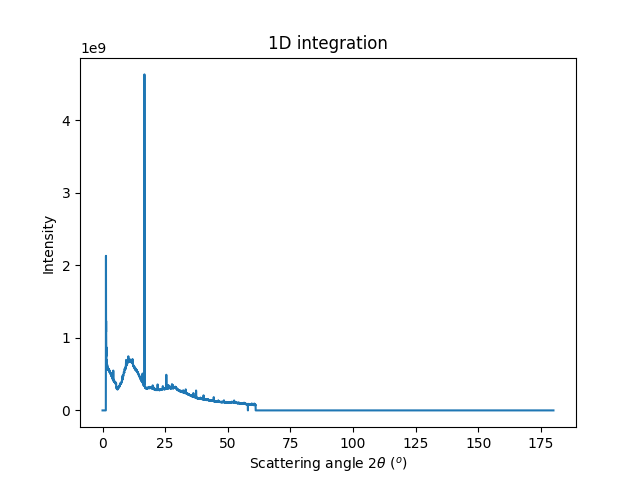

<IPython.core.display.Javascript object>


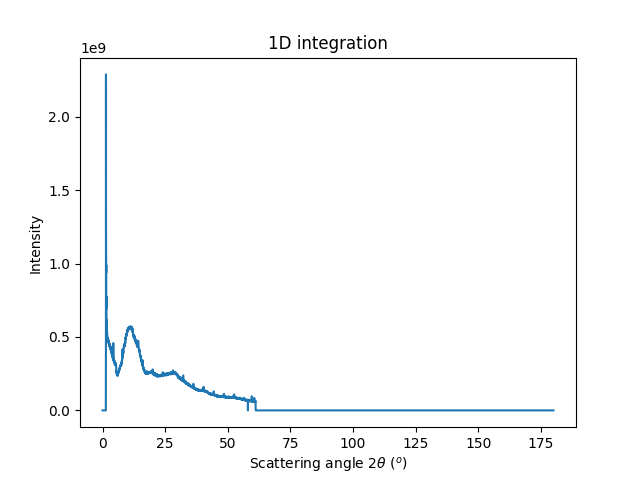

<IPython.core.display.Javascript object>


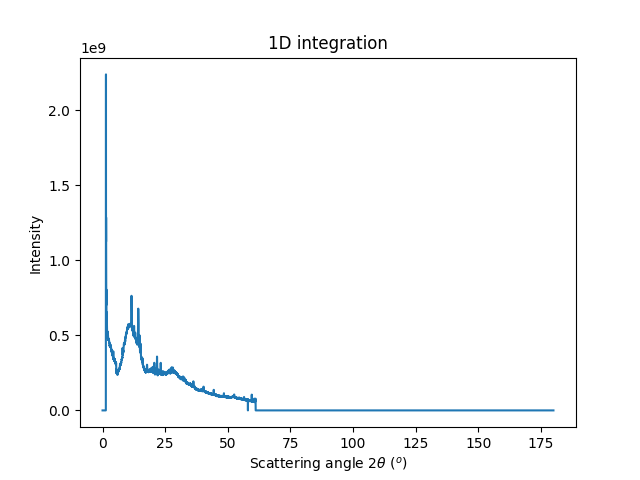

<IPython.core.display.Javascript object>


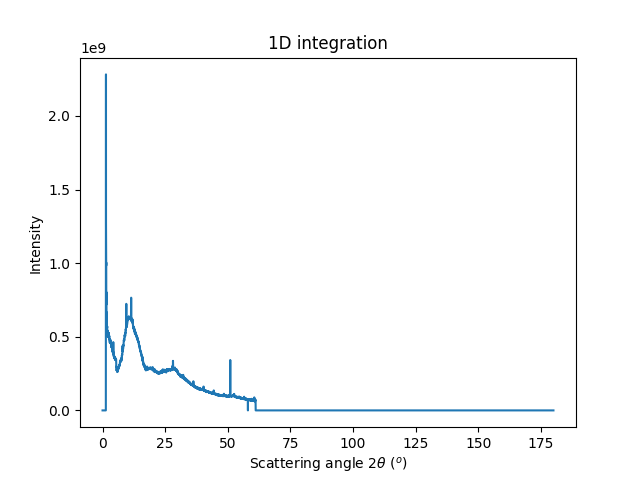

In [34]:
# integrate all the diffractogram

# let's take all the images
def to_use_sample(frame: CalibrationFrame) -> bool:
    return True

ceo2 = Calibration(os.path.join(PUBLISHED, "xrd", "calibration"),
                   os.path.join(ROOT, "2017-11-15", "scan_81.nxs"),
                   DatasetPathWithAttribute("interpretation", b"image"),
                   DatasetPathContains("scan_data/actuator_1_1"),
                   [1],
                   to_use_sample,
                   Calibrant("CeO2"),
                   Detector("imxpads140"),
                   Wavelength(6.81231e-11),
                   functions
                   )

crevette = Calibration(os.path.join(PUBLISHED, "xrd", "crevette"),
                   os.path.join(ROOT, "2017-11-15", "scan_71.nxs"),
                   DatasetPathWithAttribute("interpretation", b"image"),
                   DatasetPathContains("scan_data/actuator_1_1"),
                   [1],
                   to_use_sample,
                   Calibrant("CeO2"),
                   Detector("imxpads140"),
                   Wavelength(6.81231e-11),
                   functions
                   )

#samples = [ os.path.join(ROOT, f) for f in [os.path.join("2017-11-%d" %d in jours, "scan_%d.nxs" %d in scans)]

jours = list(range(15, 20))
scans = [[71] + list(range(74, 78)),
         list(range(82, 108)), 
         list(range(108, 124)) + list(range(129, 143)), 
         list(range(147, 158)) + list(range(163, 168)),
         list(range(168, 173)) + list(range(175, 191))         
         ]
#jours = [16]
#scans = [[82]]

samples = []           

for j, ss in zip(jours, scans):
    date = os.path.join(ROOT, "2017-11-{:d}".format(j))
    for s in ss:
        cal = Calibration(os.path.join(PUBLISHED, "xrd", "samples"),
                          os.path.join(date, "scan_{:d}.nxs".format(s)),
                          DatasetPathWithAttribute("interpretation", b"image"),
                          DatasetPathContains("scan_data/actuator_1_1"),
                          [1],
                          to_use_sample,
                          Calibrant("CeO2"),
                          Detector("imxpads140"),
                          Wavelength(6.81231e-11),
                          functions
                          )
        samples.append(cal)
        

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

#integrate(json, ceo2, f)
for s in samples: 
    integrate(json, s, f, save=True, n=10000, lst_mask=mask)
    my_cmd_button("silx view --use-opengl-plot " + s.filename,
                  'Silx View ' + os.path.basename(s.filename))